In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# I. About the dataset

- We use the dataset **Energy balance matrix** from 1970 to 2021 of Brazil. The dataset is downloaded in the website of 
Olade.

https://sielac.olade.org/

data here: https://github.com/NamNguyen2015/TFM/blob/main/datas/Option_B/Brazil_Energy%20balance%20matrix.xlsx

- The calculations for data processing base on the **Manual Olade 2011**

https://github.com/NamNguyen2015/TFM/blob/main/reference_documents/Manual%20Olade%202011.pdf

## I.1 Load the dataset

In [3]:
# Load the file
import requests
from io import BytesIO
file_path = '../datas/Option_B/Brazil_Energy balance matrix.xlsx'
url="https://github.com/NamNguyen2015/TFM/blob/main/datas/Option_B/Brazil_Energy%20balance%20matrix.xlsx"

#File excel with multi-sheet_names is read as an Dictionary
Dict = pd.read_excel(url, sheet_name=None, skiprows=range(4), skipfooter=3)


# Create a new dictionary to store modified dataframes
modified_dict = {}

for k, df in Dict.items():
    # Round the values of each column in the dataframe with 2 decimals
    df = df.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

    # Ignore the first row (unit) in each df
    df = df.iloc[1:]

    # Rename columns in df
    df.rename(columns={'Unnamed: 0': 'SECTOR', 'OTHER PRIMARY_x000d_\n': 'OTHER PRIMARY'}, inplace=True)

    # Remove space in column names and Sector names
    df.columns = df.columns.str.strip()
    df['SECTOR'] = df['SECTOR'].str.strip()

    # Rename in a row
    df['SECTOR'].replace({'COKE PLANTS AND BLAST FURNACES_x000d_': 'COKE PLANTS AND BLAST FURNACES'}, inplace=True)
    
    # fill nule values
    df=df.fillna(np.nan)

    # Convert the keys of Dict to only contain the year
    k_new = k.split(' - ')[0]
    df["YEAR"] = k_new

    # Change all column names to uppercase
    df.columns = df.columns.str.upper()

    # Store the modified dataframe in the new dictionary
    modified_dict[k_new] = df

# Update the original dictionary with the modified dataframes
Dict = modified_dict


print(Dict.keys())

#Save the Clean Dictionary in Excel with multi-sheet_names
file_path='../datas/Option_B/Datas_cleaned/Brazil_Energy balance matrix_cleaned.xlsx'
    
with pd.ExcelWriter(file_path) as writer:
    for k, df in Dict.items():
        df.to_excel(writer, sheet_name=k)



ValueError: Excel file format cannot be determined, you must specify an engine manually.

## I.2 Frist visualization of energy balance (Supply-Transformation-Adjustment-Consumption)

In [3]:
# Concatenate the data
for k in Dict.keys():    
     # Concatenate all DataFrames in Dict vertically
    df_concat = pd.concat(Dict.values(), ignore_index=True)
    df_concat.set_index("YEAR", inplace=True)
    df_concat.index = df_concat.index.astype(int)
    #df_concat.index = pd.to_datetime(df_concat.index, format='%Y')
    
df_concat.head()

SECTOR       OIL  NATURAL GAS     COAL  HYDROENERGY  GEOTHERMAL  \
YEAR                                                                          
1970    PRODUCTION   8161.58      1102.24  1044.43      3421.52         NaN   
1970        IMPORT  17845.05          NaN  1358.47          NaN         NaN   
1970        EXPORT     65.05          NaN      NaN          NaN         NaN   
1970  STOCK CHANGE   -277.33          NaN  -167.52          NaN         NaN   
1970        UNUSED       NaN       922.22      NaN          NaN         NaN   

      NUCLEAR  FIREWOOD  SUGARCANE AND PRODUCTS  OTHER PRIMARY  ...  \
YEAR                                                            ...   
1970      NaN  31851.53                  3600.7         223.24  ...   
1970      NaN       NaN                     NaN            NaN  ...   
1970      NaN       NaN                     NaN            NaN  ...   
1970      NaN       NaN                     NaN            NaN  ...   
1970      NaN       NaN                     NaN            NaN  ...   

      KEROSENE/JET FUEL  DIESEL OIL  FUEL OIL   COKE  CHARCOAL   GASES  \
YEAR                                                                     
1970            1307.21     5674.61   8399.23  55.18   1766.75  465.95   
1970               8.19         NaN       NaN  72.42       NaN     NaN   
1970             122.91       47.15    748.34    NaN       NaN     NaN   
1970             -54.86      -42.01    -69.03 -24.83       NaN     NaN   
1970                NaN         NaN       NaN    NaN       NaN   55.88   

      OTHER SECONDARY  NON-ENERGY  TOTAL SECUNDARIES     TOTAL  
YEAR                                                            
1970           321.73      886.77           31068.07  49405.24  
1970              NaN      368.92             937.48  20141.01  
1970              NaN         NaN             920.12    985.17  
1970            15.41      -53.93            -345.28   -790.13  
1970            50.45         NaN             106.33   1028.54  

[5 rows x 24 columns]

### Show the data summary over years

In [4]:
# Group by Year and SECTOR, and sum the TOTAL values
selected_SECTORS=['TOTAL SUPPLY','TOTAL TRANSFORMATION','ADJUSTMENT','FINAL CONSUMPTION']
df_summary=df_concat.copy()

#df_summary=df_summary.apply(lambda column: column.fillna(0))
df_summary=df_summary[df_summary['SECTOR'].isin(selected_SECTORS)]
df_summary = df_summary.groupby(['YEAR','SECTOR'])['TOTAL'].sum().reset_index()
# Pivot the data
df_summary = df_summary.pivot(index='YEAR', columns='SECTOR', values='TOTAL')

# Reorder the columns in df
df_summary = df_summary[selected_SECTORS]

# Display the resultdf_summary
df_summary.head()

SECTOR  TOTAL SUPPLY  TOTAL TRANSFORMATION  ADJUSTMENT  FINAL CONSUMPTION
YEAR                                                                     
1970        66742.40              -5422.47        1.85           58834.12
1971        70092.03              -5437.72        4.11           61691.69
1972        75111.33              -5936.88      -29.62           65995.12
1973        81963.44              -6488.78      -17.64           71692.86
1974        87628.20              -6959.24       25.71           76198.40

### Visualize the data summary

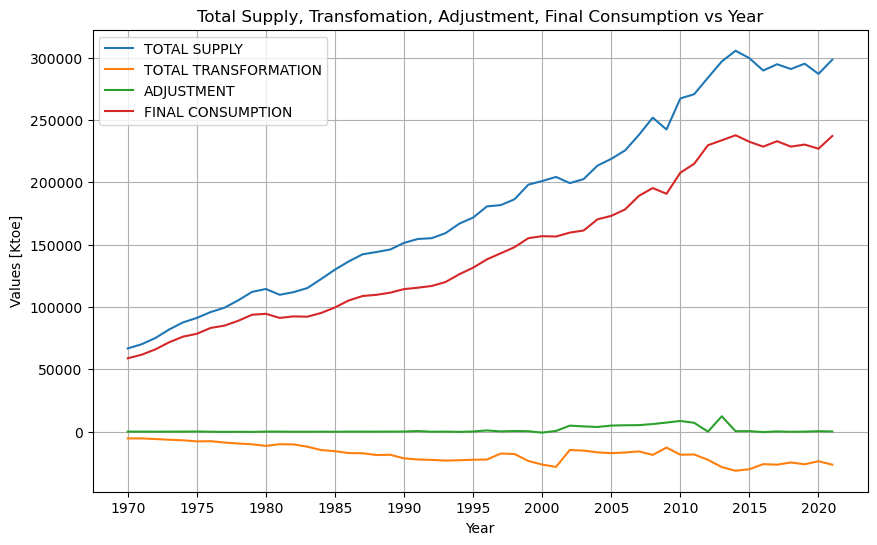

In [5]:
#selected_SECTORS=['TOTAL SUPPLY','TOTAL TRANSFORMATION','ADJUSTMENT','FINAL CONSUMPTION']
# Create a figure and axis
fig, ax = plt.subplots(figsize=( 10,6))

#for k in selected_SECTORS:
 #   df_k=df_concat.loc[df_concat["SECTOR"]==k].drop(columns=["SECTOR"], axis=1)
  #  sns.lineplot(data=df_k, x=df_k.index, y='TOTAL', label=k, ax=ax)

for col in df_summary.columns:
    sns.lineplot(data=df_summary[col], x=df_summary.index, y=df_summary[col], label=col, ax=ax)
        
# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel(f'Values [Ktoe]')
ax.set_title(f'Total Supply, Transfomation, Adjustment, Final Consumption vs Year')
ax.set_xticks(df_summary.index.unique()[::5])

# Show the legend
ax.legend()

# Show the plot
plt.grid(True)
plt.show()




The negative transformation values over  years typically means that more energy was consumed or transformed within the energy system than was produced or input into the system during that specific time period (year). In other words, it indicates an energy deficit or a situation where the energy demands and transformations within the system exceeded the energy available from primary sources or imports.

## I.3 Sankey Diagram

- Sankey diagrams are valuable tools for visualizing energy flows and understanding energy balances in complex systems. 

- Reviewing Sankey diagrams in an energy balance context is crucial for gaining insights into energy flows, identifying inefficiencies, ensuring a balance between supply and demand, and making informed decisions about energy policy, efficiency improvements, and environmental management. They provide a concise and visually intuitive representation of complex energy data, making it easier for stakeholders to understand and act upon energy-related challenges and opportunities.

In [6]:
from collections import defaultdict
import plotly.graph_objects as go

### Define the Plot function

In [7]:
# Defining the Plot function
def Plot(year,db):
    label=db[year]["label"]
    source=db[year]["source"]
    target=db[year]["target"]
    value=db[year]["value"]
    color_nodes=db[year]["color_nodes"]
    color_links=db[year]["color_links"]
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 30,
          thickness = 20,
          line = None, # dict(color = "black", width = 0.5),
          label = label,
          color = color_nodes
        ),
        link = dict(
          source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target,
          value = value,
            color=color_links
      ))])

    fig.update_layout(title_text=year, font_size=10)
    fig.show()

#### Preparation the data to plot

In [8]:
# Preparation the data to plot
def Data_Generate(Dict):
    
    Dict_out = {}  # Initialize the output dictionary
    for sheet_name in Dict.keys():

        df=Dict[sheet_name]
        
         # Reset index
        df=df.set_index('SECTOR')

        # Transpose df
        df=df.T

        # Fill NaN values
        df=df.fillna(np.nan)
       

        # define the combinations
        Transformers=['REFINERIES', 'POWER PLANTS', 'SELF-PRODUCERS',
               'GAS PLANTS', 'CHARCOAL PLANTS', 'COKE PLANTS AND BLAST FURNACES',
               'DISTILLERIES', 'OTHER CENTERS']
        Primaries=['OIL','NATURAL GAS','COAL','HYDROENERGY','GEOTHERMAL','NUCLEAR','FIREWOOD','SUGARCANE AND PRODUCTS','OTHER PRIMARY']
        Secondaries=['ELECTRICITY','LPG','GASOLINE/ALCOHOL','KEROSENE/JET FUEL','DIESEL OIL','FUEL OIL','COKE','CHARCOAL','GASES','OTHER SECONDARY']
        Consumptions=['TRANSPORT','INDUSTRIAL','RESIDENTIAL','COMMERCIAL, SERVICES, PUBLIC','AGRICULTURE, FISHING AND MINING','CONSTRUCTION AND OTHERS']

        unique_combinations = []

        # here add secondary combination then type of consumption combination

        for i in Transformers:
            for j in Primaries:
                unique_combinations.append((j, i,abs(df[i][j])))

        for i in Transformers:
            for j in Secondaries:
                unique_combinations.append((i, j,abs(df[i][j])))

        # the final consumption column - Usage column
        for i in Consumptions:
            for j in Primaries+Secondaries:
                unique_combinations.append((j, i,abs(df[i][j])))
                
        label=Transformers+Primaries+Secondaries+Consumptions+Primaries+Secondaries
        
        #colors
        color_Transformers=['blue','yellow','green','orange','grey','grey','pink','cyan']
        color_Primaries=['black','orange','darkgray','lightblue','darkred','red','brown','darkgreen','khaki']
        color_Secondaries=['yellow','lightgreen','plum','plum','plum','grey','grey','grey','grey']
        color_Consumptions=['darkmagenta' for i in range(9)]
        color_nodes=color_Transformers+color_Primaries+color_Secondaries+color_Consumptions+color_Primaries+color_Secondaries
        
        # Rename the sheet_name to contain only year. Sample: "1970 - Brazil"--> "1970"
        sheet_name_new = sheet_name.split(' - ')[0]
    
        _dict=Dict_out[sheet_name_new]={}
        _dict["source"]=[]
        _dict["target"]=[]
        _dict["value"]=[]
        _dict["label"]=label
        _dict["color_nodes"]=color_nodes
        _dict["color_links"]=[]
        


        #Dict_out[sheet_name_new] = data  # Store the data in the dictionary
        for k in unique_combinations:
            _dict["source"].append(label.index(k[0]))
            _dict["target"].append(label.index(k[1]))
            _dict["value"].append(k[2])
            _dict["color_links"].append(color_nodes[label.index(k[0])])
    return Dict_out

In [9]:
db=Data_Generate(Dict)

### Sample plot

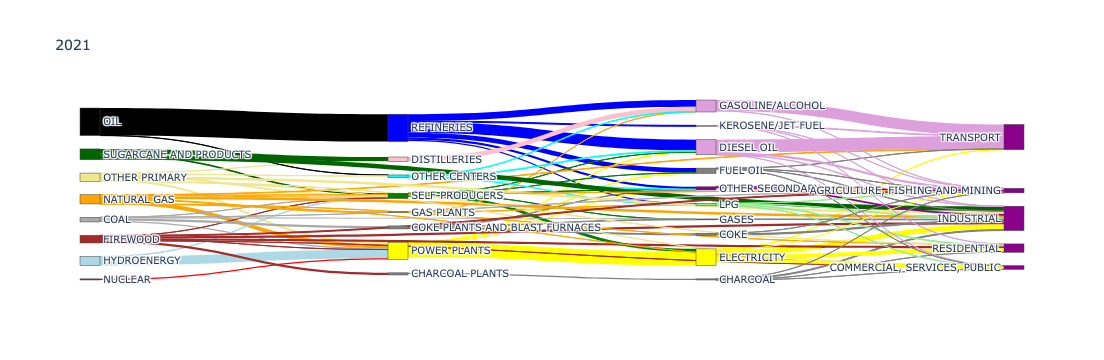

In [10]:
Plot(year='2021',db=db)

## II. DATA ANALYSIS CONSUMPTION



In [11]:
# Show the df final consumption:
df_C=df_concat.copy()

selected_SECTORS_C=['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS',
       'NON-ENERGY CONSUMPTION','FINAL CONSUMPTION']

df_C=df_C[df_C['SECTOR'].isin(selected_SECTORS_C)]
df_C = df_C.groupby(['YEAR','SECTOR'])['TOTAL'].sum().reset_index()
# Pivot the data
df_C = df_C.pivot(index='YEAR', columns='SECTOR', values='TOTAL')

# Reorder the columns in df
df_C = df_C[selected_SECTORS_C]

# Display the resultdf_summary
df_C.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
1970     12661.99    16020.92     22075.66                       1266.80   
1971     13841.87    17454.73     22253.96                       1406.98   
1972     15633.22    19026.99     22440.87                       1570.69   
1973     18328.90    21493.43     22354.13                       1737.84   
1974     20105.68    23257.01     22316.70                       1873.46   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
1970                            5351.01                     0.00   
1971                            5317.39                     0.00   
1972                            5338.47                     0.00   
1973                            5441.91                     0.00   
1974                            5376.38                     7.15   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
1970                   1457.73           58834.12  
1971                   1416.75           61691.69  
1972                   1984.88           65995.12  
1973                   2336.65           71692.86  
1974                   3262.03           76198.40

In [12]:
# df_C_percentages calculate the percentages

df_C_percentages = (df_C.drop(columns=['FINAL CONSUMPTION']).div(df_C['FINAL CONSUMPTION'], axis=0) * 100)
df_C_percentages = df_C_percentages.round(0)

df_C_percentages.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION'],
      dtype='object', name='SECTOR')

In [13]:
# Drop the 'FINAL CONSUMPTION' column (if not already dropped) as it is not needed for the stack plot
df_stackplot = df_C.drop(columns=["FINAL CONSUMPTION"])



### a- Show the line_plot:

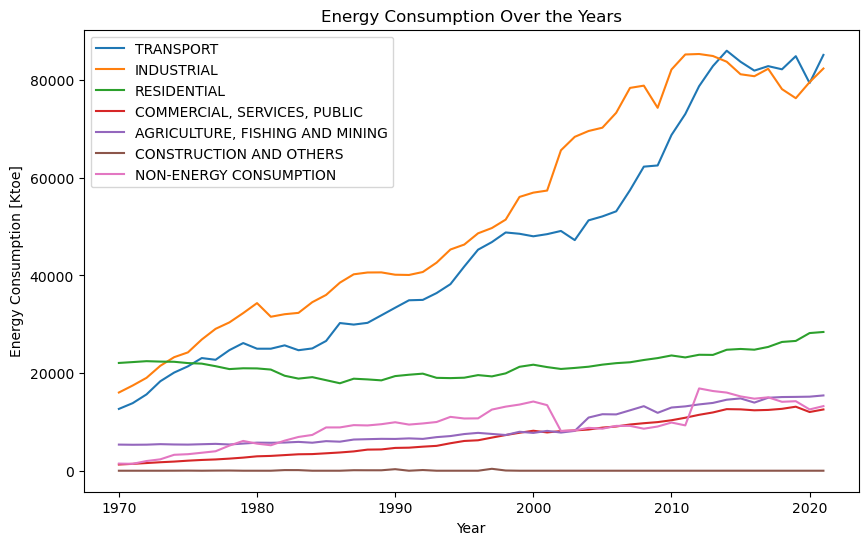

In [14]:
data=df_stackplot.copy()

# Line_Plot:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

data.plot(ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Energy Consumption [Ktoe]')
ax1.set_title('Energy Consumption Over the Years')
ax1.legend(loc='upper left')

plt.show()

### b- Plot both stack plots side by side

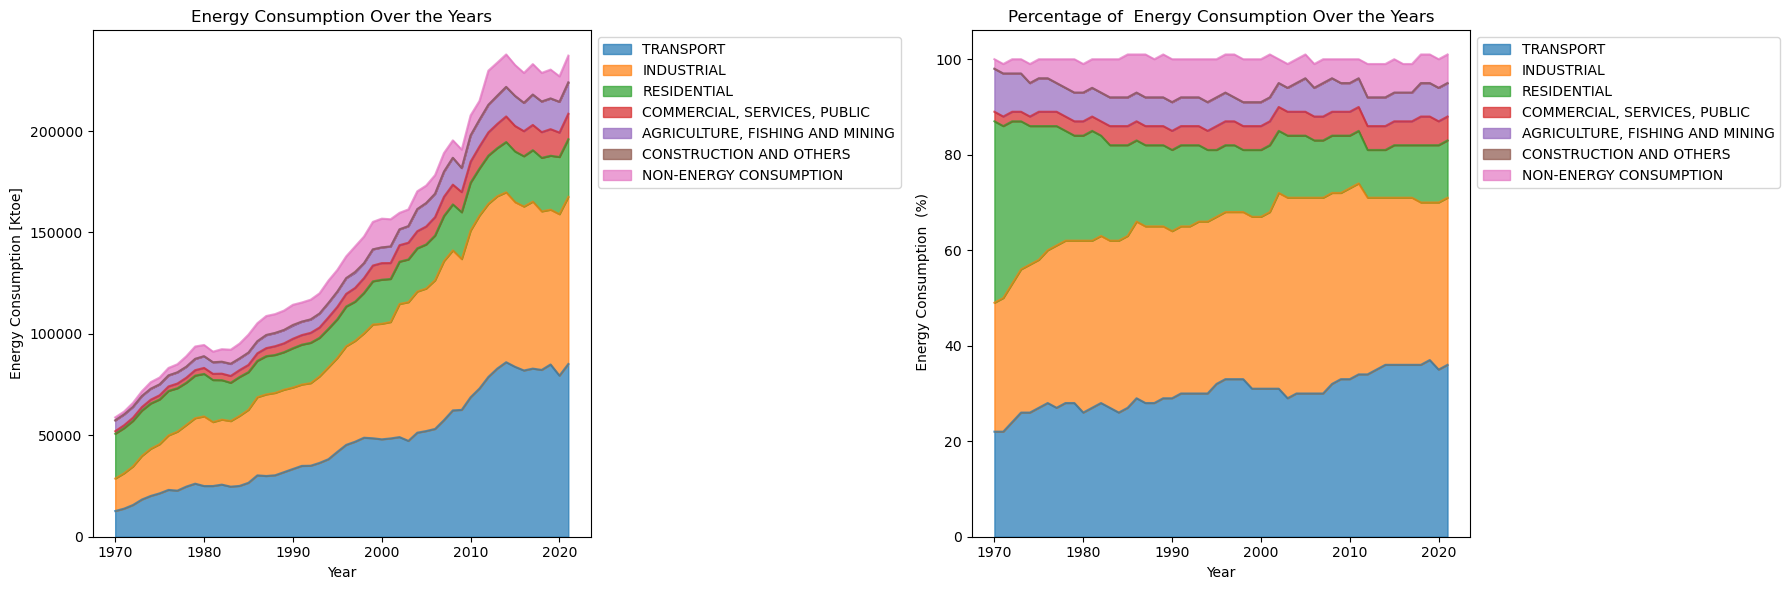

In [15]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))

df_stackplot.plot.area(stacked=True, alpha=0.7, ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Energy Consumption [Ktoe]')
ax1.set_title('Energy Consumption Over the Years')
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

df_C_percentages.plot.area(stacked=True, alpha=0.7, ax=ax2)

ax2.set_xlabel('Year')
ax2.set_ylabel(' Energy Consumption  (%)')
ax2.set_title('Percentage of  Energy Consumption Over the Years')
ax2.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

### CORRELATION MATRIX

In [16]:
#df_C.index = pd.to_datetime(df_C.index, format='%Y')
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

In [17]:

list_corr=df_C.columns.drop(['FINAL CONSUMPTION'])

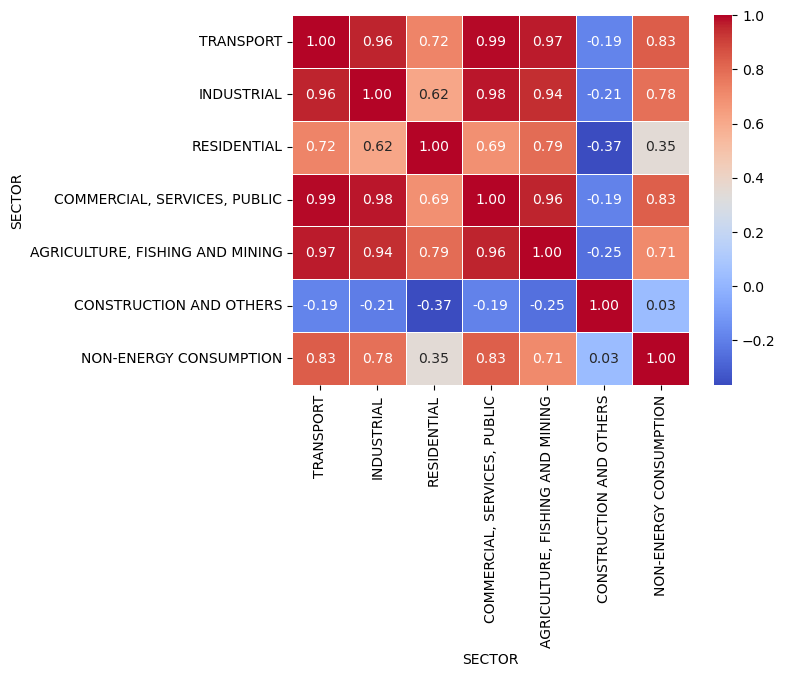

In [18]:

corr_mat = df_C[list_corr].corr()
sns.heatmap(corr_mat,annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.show()

From the correlation matrix, we can observe that the sector **'CONSTRUCTION AND OTHERS'** has a very low correlation with other sectors. We can consider dropping it if necessary.

In [19]:
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

## Scaled data

### MinMaxScaler
<img src="attachment:e9c23a6d-74b4-446c-810b-9ceb0da41f8e.png" width="300">

In [20]:
df_C.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
1970     12661.99    16020.92     22075.66                       1266.80   
1971     13841.87    17454.73     22253.96                       1406.98   
1972     15633.22    19026.99     22440.87                       1570.69   
1973     18328.90    21493.43     22354.13                       1737.84   
1974     20105.68    23257.01     22316.70                       1873.46   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
1970                            5351.01                     0.00   
1971                            5317.39                     0.00   
1972                            5338.47                     0.00   
1973                            5441.91                     0.00   
1974                            5376.38                     7.15   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
1970                   1457.73           58834.12  
1971                   1416.75           61691.69  
1972                   1984.88           65995.12  
1973                   2336.65           71692.86  
1974                   3262.03           76198.40

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_C)
scaled_df = pd.DataFrame(scaled_data, columns=df_C.columns)
scaled_df.set_index(df_C.index, inplace=True)

In [22]:
scaled_df.head()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
1970     0.000000    0.000000     0.395950                      0.000000   
1971     0.016081    0.020678     0.412922                      0.011833   
1972     0.040495    0.043352     0.430713                      0.025652   
1973     0.077235    0.078921     0.422457                      0.039761   
1974     0.101450    0.104355     0.418894                      0.051209   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
1970                           0.003327                 0.000000   
1971                           0.000000                 0.000000   
1972                           0.002086                 0.000000   
1973                           0.012323                 0.000000   
1974                           0.005838                 0.018204   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
1970                  0.002654           0.000000  
1971                  0.000000           0.015970  
1972                  0.036794           0.040021  
1973                  0.059575           0.071865  
1974                  0.119505           0.097046

### Running ARIMA

We apply the ARIMA model to all sectors, but first, we need to perform some checks to select the best parameters **(p, d, q)**.

In time series analysis, whether we need to scale the data (i.e., standardize or normalize it) depends on the specific characteristics of the data and the modeling techniques we plan to use. Scaling may or may not be required.

In this section, we are focusing on modeling the **univariate** problem, so **scaling is negligible**.

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score

In [24]:

# Split data into train and test sets 
train_size = int(len(df_C) * 0.80)

# Separate the data into 2 parts: training and validation
data_tr= df_C.iloc[:train_size]
data_val=df_C.iloc[train_size:]


In [25]:
data_tr.tail()

SECTOR  TRANSPORT  INDUSTRIAL  RESIDENTIAL  COMMERCIAL, SERVICES, PUBLIC  \
YEAR                                                                       
2006     53138.32    73324.16     22034.81                       9060.76   
2007     57478.13    78418.45     22216.18                       9467.70   
2008     62289.25    78879.36     22681.60                       9732.39   
2009     62530.21    74338.79     23071.27                       9958.74   
2010     68765.74    82179.55     23610.56                      10339.55   

SECTOR  AGRICULTURE, FISHING AND MINING  CONSTRUCTION AND OTHERS  \
YEAR                                                               
2006                           11535.36                      0.0   
2007                           12375.19                      0.0   
2008                           13222.55                      0.0   
2009                           11860.91                      0.0   
2010                           12945.44                      0.0   

SECTOR  NON-ENERGY CONSUMPTION  FINAL CONSUMPTION  
YEAR                                               
2006                   9183.32          178276.74  
2007                   9185.24          189140.88  
2008                   8607.79          195412.94  
2009                   9054.90          190814.83  
2010                   9871.64          207712.48

In [26]:
#data_val.head()

In [27]:
#df_C.columns

### Prepare Functions

In [28]:
import warnings

# Suppress specific warning by category (e.g., FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
from sklearn.metrics import mean_absolute_percentage_error 

def MAPE(actual,forecast):
      # Ensure both DataFrames have the same shape
    if actual.shape != forecast.shape:
        raise ValueError("Input data shapes must match.")

    # Replace zero values in y_true with a small non-zero value to avoid division by zero
    actual = actual.replace(0, 1e-10)

    # Calculate the mean of absolute percentage errors 
    mape= round(abs((actual.to_numpy() - forecast.to_numpy()) / actual.to_numpy()).mean()*100,2)

    return mape

In [30]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

## II.1. Sample sector (TRANSPORT)- Mathematic background of ARIMA model

In [31]:
sector='TRANSPORT'
df_transport=df_C[[sector]]
df_transport.head()

SECTOR  TRANSPORT
YEAR             
1970     12661.99
1971     13841.87
1972     15633.22
1973     18328.90
1974     20105.68

In [32]:
# Train and Test data
df_tr=df_transport.iloc[:train_size]#train[['TRANSPORT']]
df_val=df_transport.iloc[train_size:]

### check stationary of the time series

In [33]:
test_stationarity(df_tr)

Results of Dickey-Fuller Test:
Test Statistic                  1.419910
p-value                         0.997203
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In this case, the p-value is almost  $1$, we can conclude that the data is not stationary.

**The next step, Partial Autocorrelation Function (PACF) is visualized.**

Showing the PACF is important in time series analysis because it helps in model selection, order determination, diagnosing the adequacy of a chosen model, and understanding the underlying autocorrelation structure of the data. 

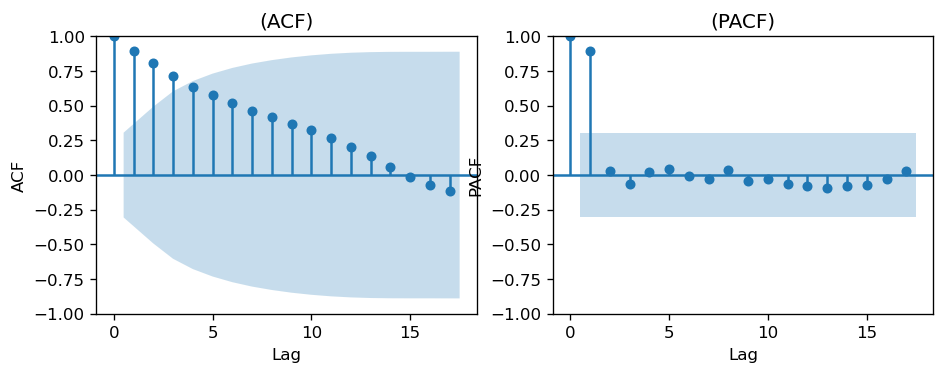

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

# Plot ACF
plot_acf(df_tr, ax=axes[0])
axes[0].set_title('(ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# Plot PACF
plot_pacf(df_tr, ax=axes[1], method='ywm')
axes[1].set_title('(PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.show()


### How to find the order of differencing (d) in ARIMA model

**Transform to stationary: differencing**

The value of **d** can be determined by finding the minimum number of differencing steps required to make the time series stationary.

In some cases, if the autocorrelations (ACF) are positive for many number of lags (10 or more), then the series needs further differencing.


<AxesSubplot:xlabel='YEAR'>

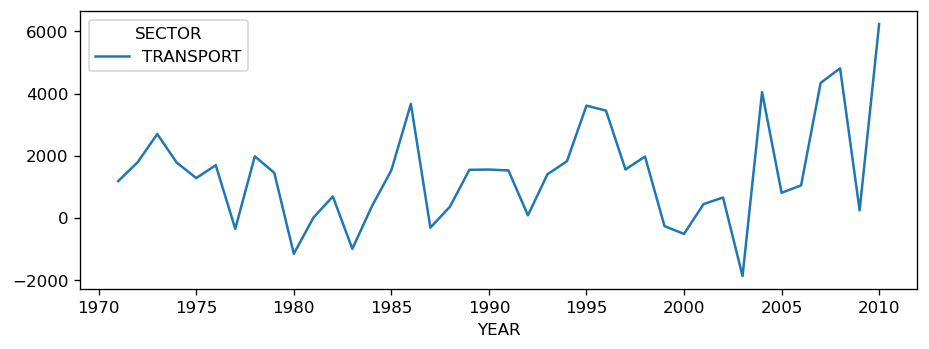

In [35]:
train_diff = df_tr.diff().dropna()
train_diff.plot()

In [36]:
#Test with diffencing data:
test_stationarity(train_diff)


Results of Dickey-Fuller Test:
Test Statistic                 -2.452644
p-value                         0.127426
#Lags Used                      4.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


p-value in the first differential is still greater than 0.05 so the second differential may need.

In [37]:
# Check the second differential:
train_diff_2=df_tr.diff().diff().dropna()
#train_diff_2.plot()


In [38]:
test_stationarity(train_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -8.368694e+00
p-value                        2.698869e-13
#Lags Used                     1.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


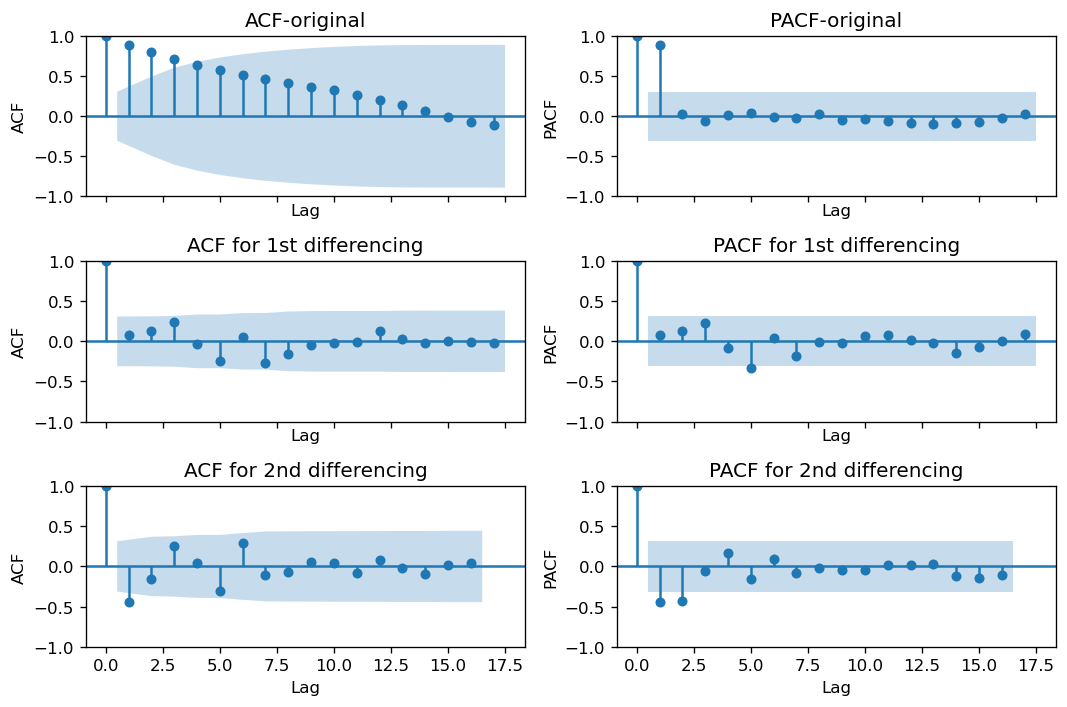

In [39]:

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (9, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=True)

# Plot ACF for original data
plot_acf(df_tr, ax=axes[0, 0])
axes[0, 0].set_title('ACF-original')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('ACF')

# Plot PACF for train
plot_pacf(df_tr, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF-original')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('PACF')


# Plot ACF for train_diff
plot_acf(train_diff, ax=axes[1, 0])
axes[1, 0].set_title('ACF for 1st differencing')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('ACF')

# Plot PACF for train_diff
plot_pacf(train_diff, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF for 1st differencing')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('PACF')

# Plot ACF for train_diff_2
plot_acf(train_diff_2, ax=axes[2, 0])
axes[2, 0].set_title('ACF for 2nd differencing')
axes[2, 0].set_xlabel('Lag')
axes[2, 0].set_ylabel('ACF')

# Plot PACF for train_diff_2
plot_pacf(train_diff_2, ax=axes[2, 1], method='ywm')
axes[2, 1].set_title('PACF for 2nd differencing')
axes[2, 1].set_xlabel('Lag')
axes[2, 1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

In the second differential, the p-value is small enough to conclude that the series is well stationary  but on looking at the autocorrelation (ACF) plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

In conclusion, we may take $d=1$ (or $2$)

We can observe from the above figures that the best combinations for **(p,d,q)** can be:
**(2,1,1),(2,2,1)**  

In [40]:
df_transport.index = pd.to_datetime(df_transport.index, format='%Y')
df_tr.index = pd.to_datetime(df_tr.index, format='%Y')
df_val.index = pd.to_datetime(df_val.index, format='%Y')
df_val.head(3)

SECTOR      TRANSPORT
YEAR                 
2011-01-01   73066.20
2012-01-01   78767.15
2013-01-01   82886.93

                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   41
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -355.784
Date:                Tue, 12 Sep 2023   AIC                            719.567
Time:                        16:56:57   BIC                            726.323
Sample:                    01-01-1970   HQIC                           722.010
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7101      0.289      2.458      0.014       0.144       1.276
ar.L2          0.1634      0.168      0.973      0.330      -0.166       0.493
ma.L1         -0.6274      0.291     -2.156      0.0

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Text(0.5, 1.0, 'TRANSPORT-MAPE=5.05')

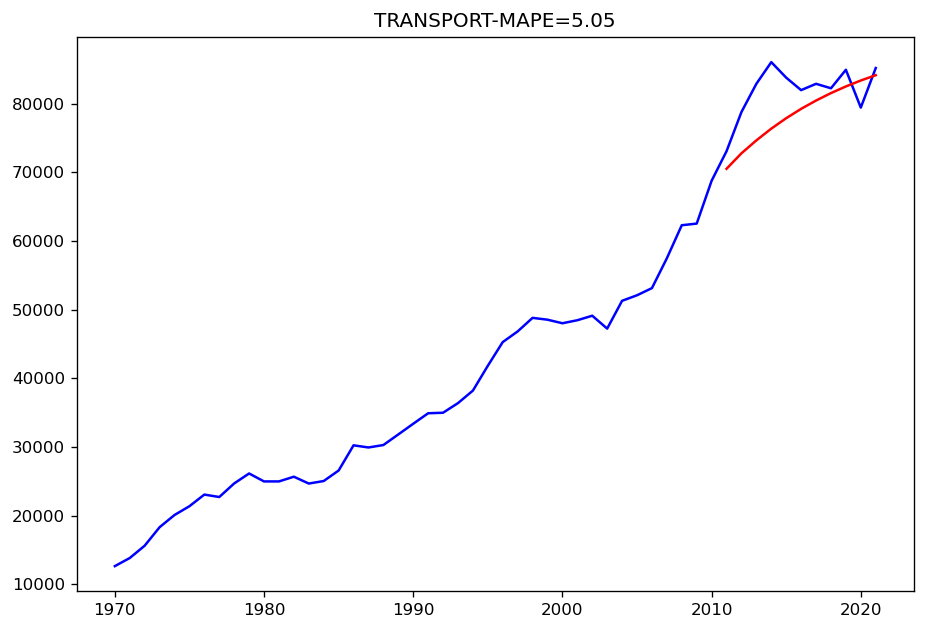

In [41]:
# check with order=(2,1,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(2,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)

#mape=round(mean_absolute_percentage_error(df_val, df_forecast),2)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f'TRANSPORT-MAPE={mape}')


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



Text(0.5, 1.0, 'TRANSPORT-MAPE=14.6')

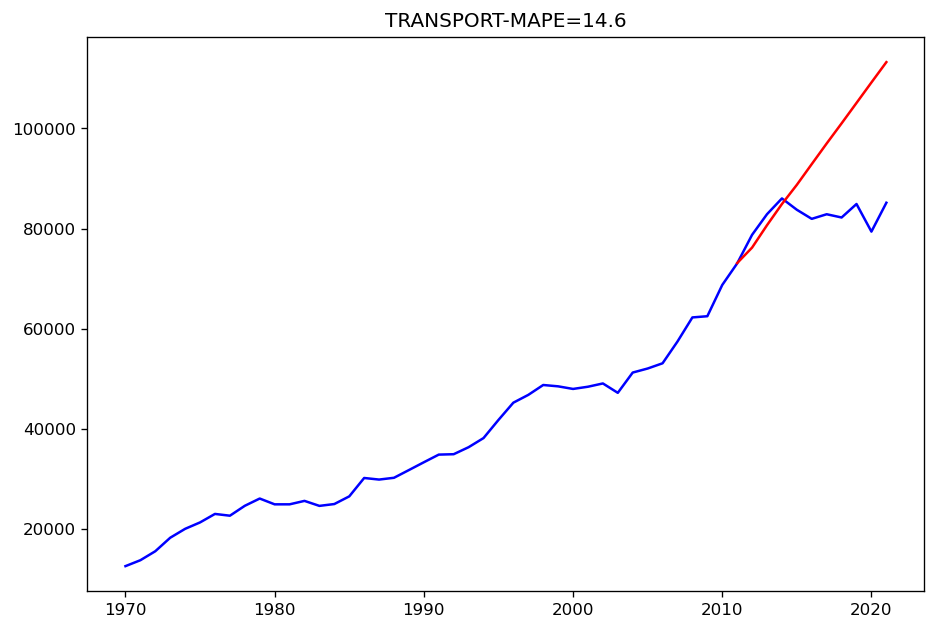

In [42]:
# check with order=(2,2,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(2,2,1)) 
model_fit = model.fit()
#print(model_fit.summary())
# Prediction

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f"TRANSPORT-MAPE={mape}")



We can observe that $(p,d,q)=(2,1,1)$ returns the better result with  MAPE=5.05% 

### Future forecast (20 more years) with 2 scenarios por renovable secondary energy

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   52
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -465.506
Date:                Tue, 12 Sep 2023   AIC                            939.011
Time:                        16:56:57   BIC                            946.738
Sample:                    01-01-1970   HQIC                           941.964
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4607      0.418      1.102      0.270      -0.359       1.280
ar.L2          0.2929      0.208      1.410      0.159      -0.114       0.700
ma.L1         -0.4135      0.431     -0.959      0.3

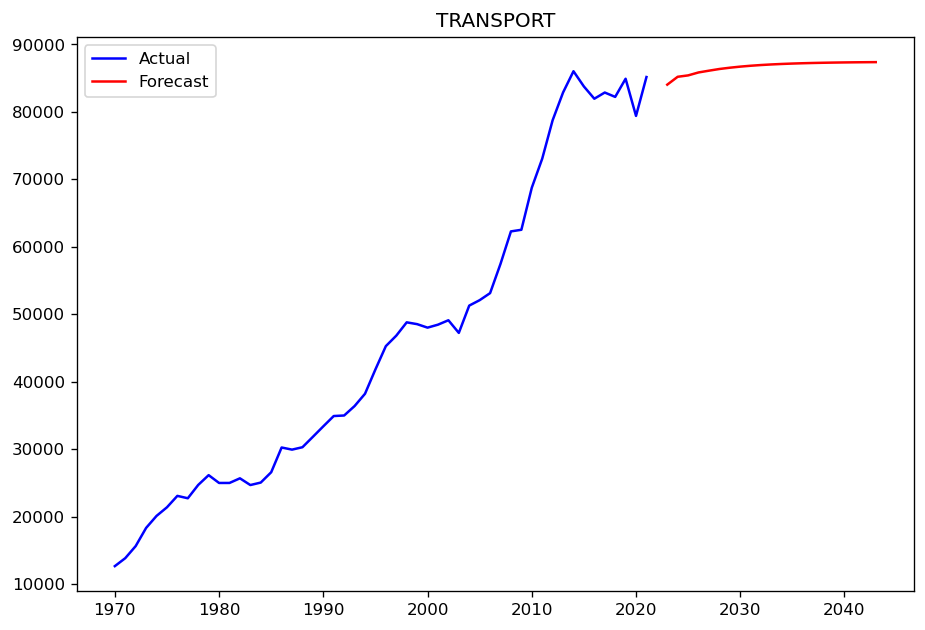

In [43]:
model = ARIMA(df_transport, order=(2,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())
warnings.filterwarnings("ignore")
# Specify the number of future steps to forecast
periods = 20  # Adjust as needed
# Specify the start date
start_date = pd.to_datetime('2022-01-01')

# Prediction for future time points
data_pred = model_fit.predict(start=start_date, end=start_date+ pd.DateOffset(years=periods))


# Create a date range for the forecasted period
forecast_index = date_range = pd.date_range(start=start_date, periods=periods+1, freq='A')

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=list(data_pred), index=forecast_index)

# Plot
plt.plot(df_transport, "b", label="Actual")
plt.plot(df_forecast, "r", label="Forecast")

plt.title("TRANSPORT")
plt.legend()
plt.show()

df_pred_TRANSPORT=df_forecast
df_pred_TRANSPORT.to_excel("pred_TRANSPORT.xlsx")


In [44]:
df_pred_TRANSPORT

0
2022-12-31  84045.301855
2023-12-31  85212.295680
2024-12-31  85418.629745
2025-12-31  85855.549938
2026-12-31  86117.271031
2027-12-31  86365.832878
2028-12-31  86557.008462
2029-12-31  86717.892949
2030-12-31  86848.012060
2031-12-31  86955.084777
2032-12-31  87042.528065
2033-12-31  87114.177274
2034-12-31  87172.800228
2035-12-31  87220.795538
2036-12-31  87260.078999
2037-12-31  87292.235829
2038-12-31  87318.557516
2039-12-31  87340.103398
2040-12-31  87357.739818
2041-12-31  87372.176206
2042-12-31  87383.993165

## How to do Auto Arima Forecast in Python?

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

## II.2. Generate for all sectors

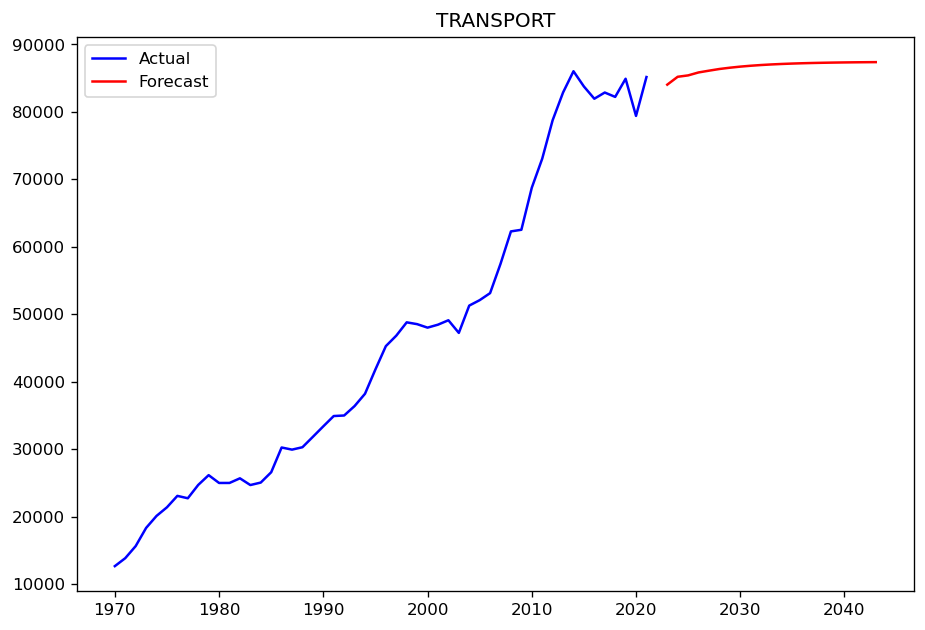

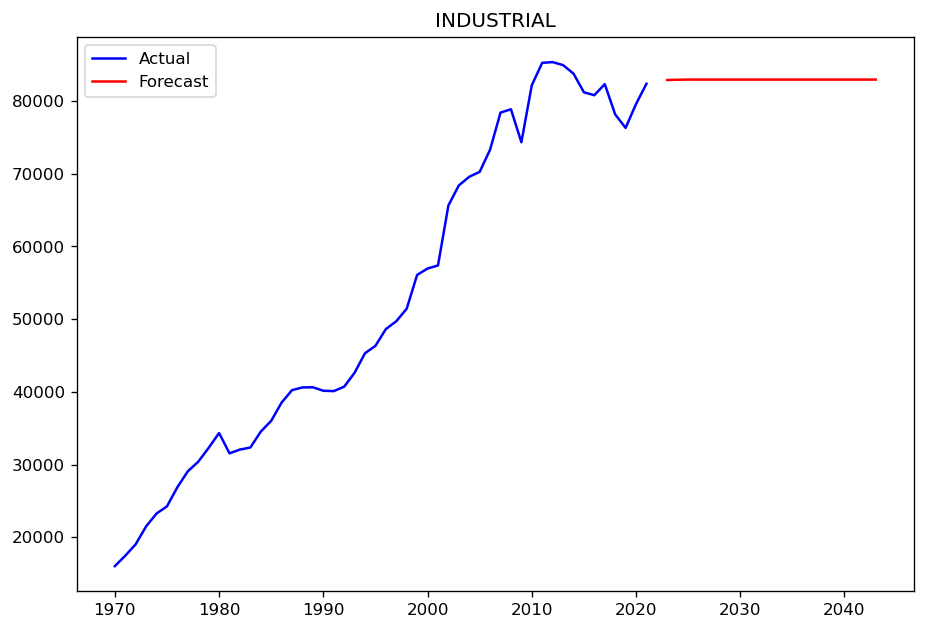

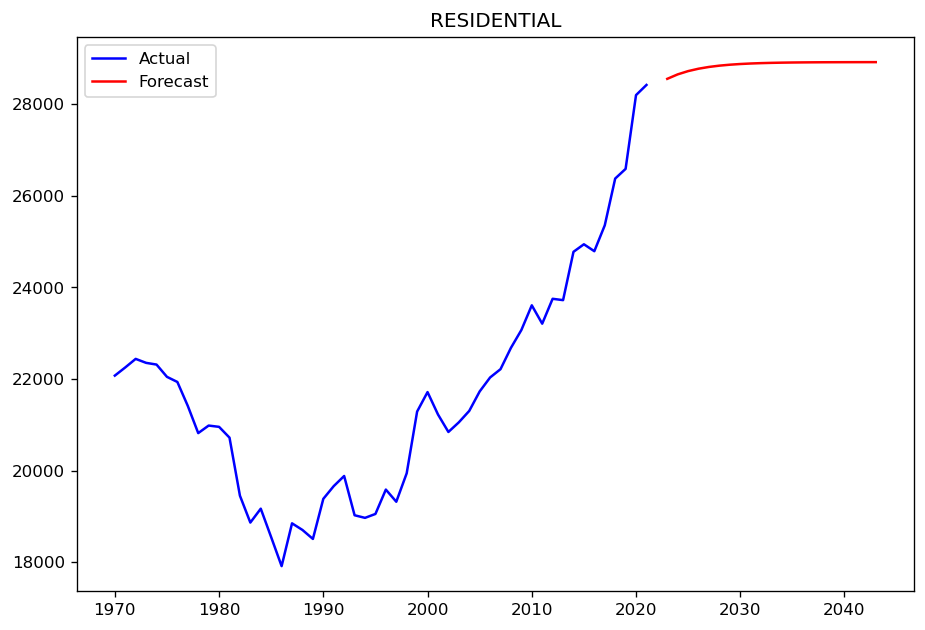

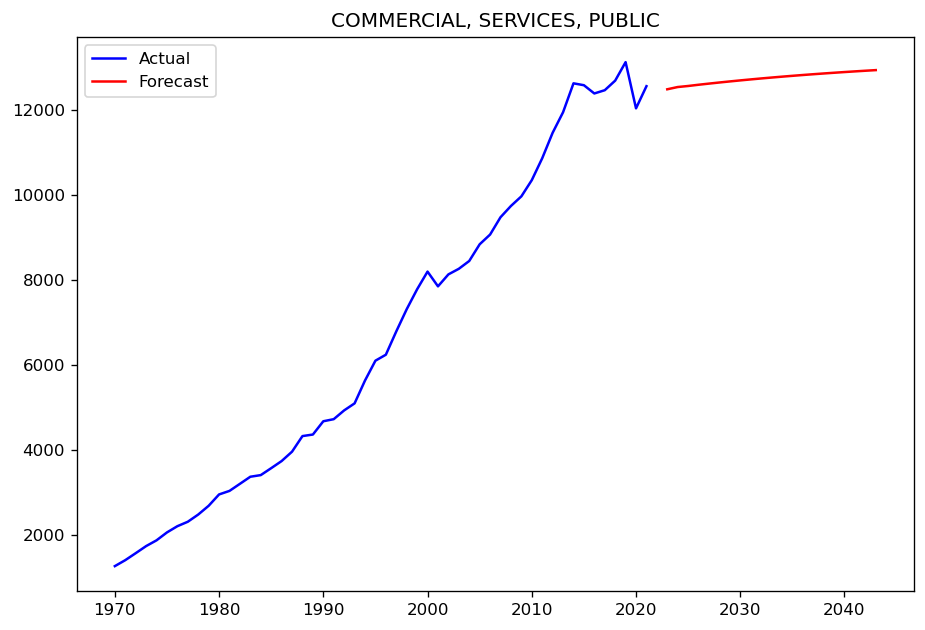

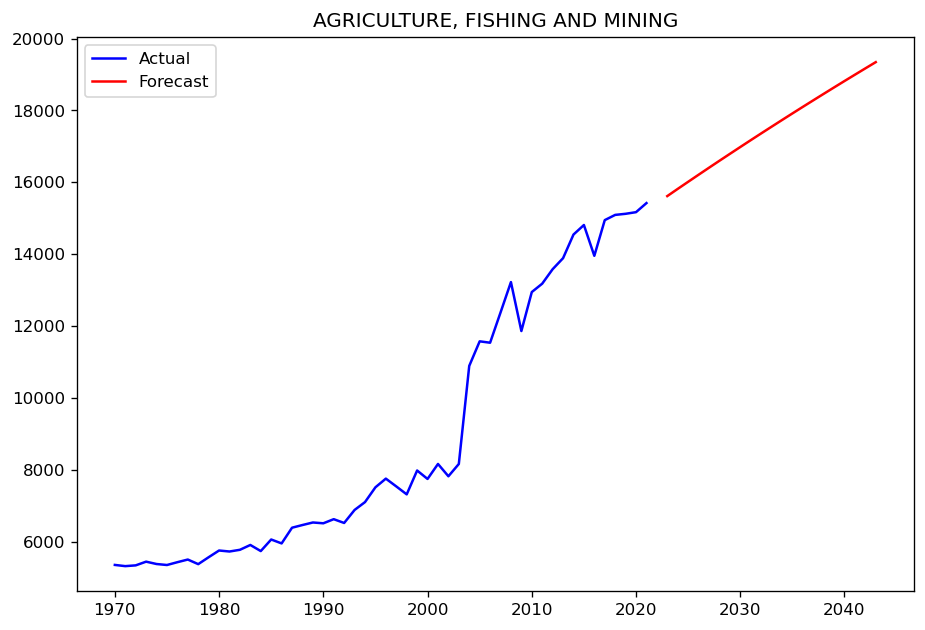

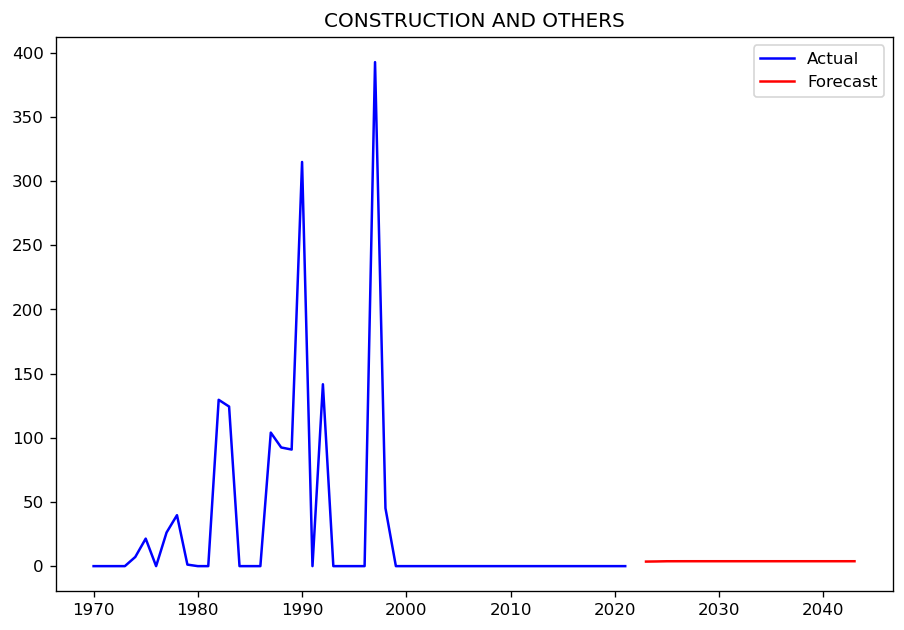

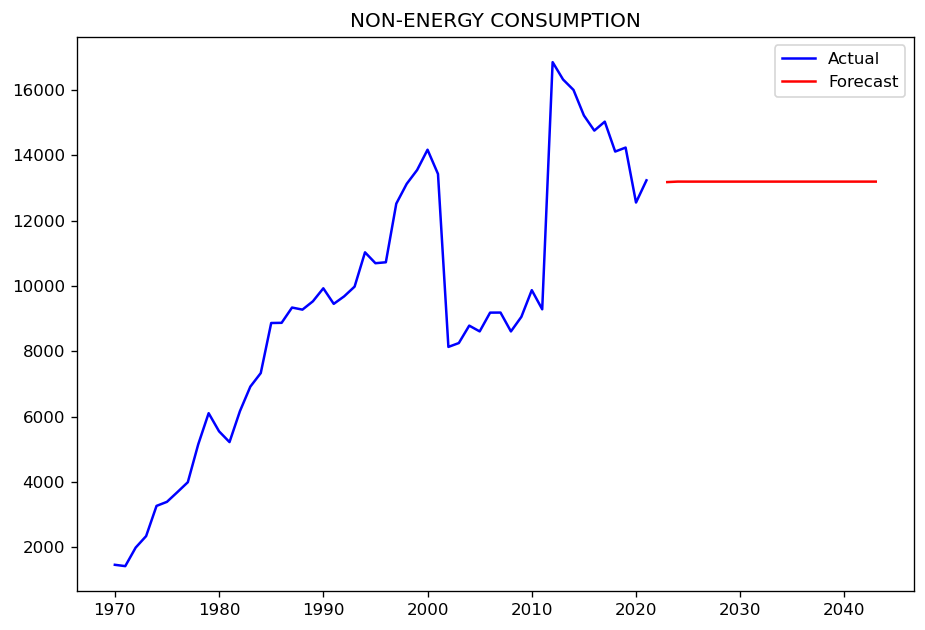

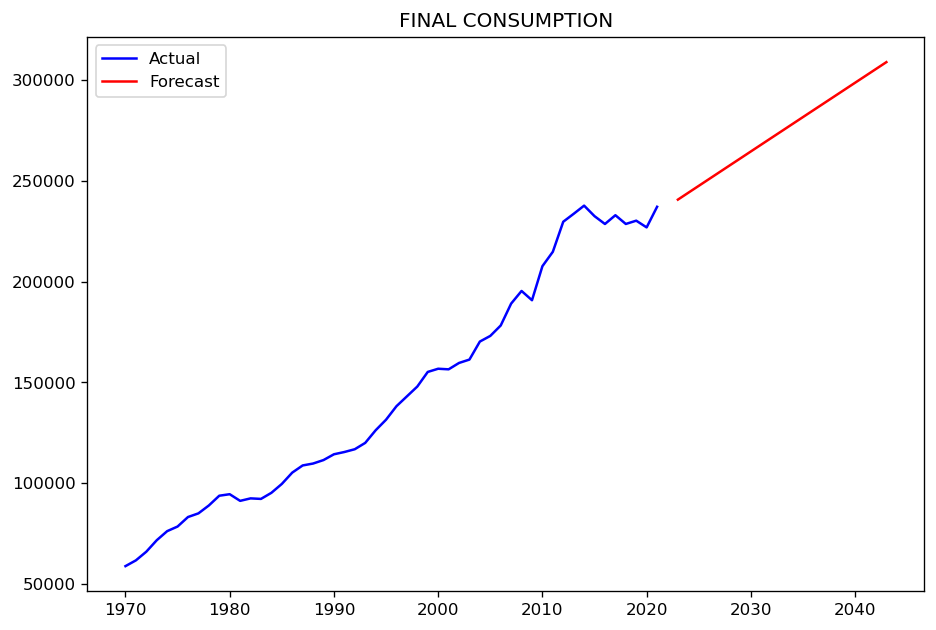

In [45]:

df_C_pred=pd.DataFrame()
for s in df_C.columns:
    
    
    # prepare data: 
    df_sector= df_C[[s]]
    df_sector.index = pd.to_datetime(df_sector.index, format='%Y')
    
    # Build model ARIMA with order=(1,1,1) or (2,1,1)
    ## We can select model here for each sector by including the condition....
    
    model = ARIMA(df_sector, order=(2,1,1)) #this combination is the best 
    model_fit = model.fit()
    
    # Specify the number of future steps to forecast
    periods = 20  # Adjust as needed
    # Specify the start date
    start_date = pd.to_datetime('2022-01-01')

    # Prediction for future time points
    data_pred = model_fit.predict(start=start_date, end=start_date+ pd.DateOffset(years=periods))

    # Create a date range for the forecasted period
    forecast_index = pd.date_range(start=start_date, periods=periods+1, freq='A')

    # Create a Pandas DataFrame with the forecasted values and set the index
    df_forecast = pd.DataFrame(data=list(data_pred), index=forecast_index, columns=[s])

    # Plot
    plt.plot(df_sector, "b", label="Actual")
    plt.plot(df_forecast, "r", label="Forecast")

    plt.title(f"{s}")
    plt.legend()
    plt.show()
    
    #Concatenate df
    df_C_pred=pd.concat([df_C_pred,df_forecast],axis=1)
# Round the values of each column in the dataframe with 2 decimals
df_C_pred = df_C_pred.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)  
df_C_pred.index=df_C_pred.index.year
# Save the df_forecast to excel
file_name='df_C_pred.xlsx'
df_C_pred.to_excel(file_name)

In [46]:
df_C_final=pd.concat([df_C, df_C_pred], axis=0)

In [47]:
df_C_final.index=df_C_final.index.astype(int)

<AxesSubplot:title={'center':'Prediction FINAL ENERGY CONSUMPTION 20 more years'}, xlabel='Year', ylabel='Values [Ktoe]'>

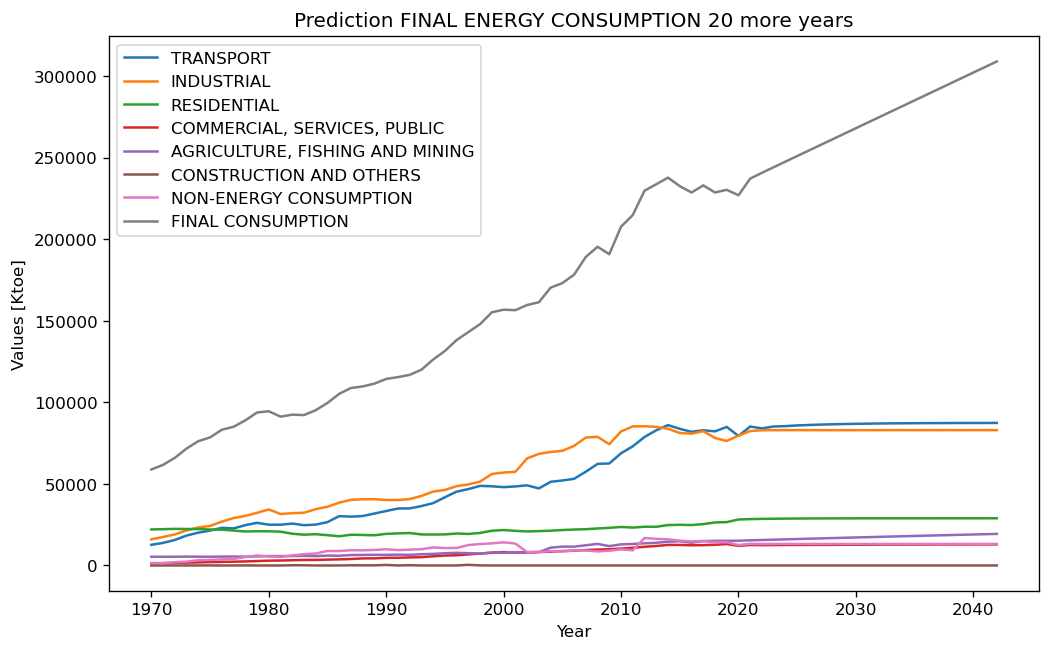

In [48]:
df_C_final.plot(figsize=(10, 6),title= "Prediction FINAL ENERGY CONSUMPTION 20 more years", xlabel= "Year", ylabel="Values [Ktoe]")

In [49]:
val_2015=df_C_final.loc[2015,'FINAL CONSUMPTION']


In [50]:
val_2015

232537.06

In [51]:
Dict

{'1970':                              SECTOR       OIL  NATURAL GAS     COAL  \
 1                        PRODUCTION   8161.58      1102.24  1044.43   
 2                            IMPORT  17845.05          NaN  1358.47   
 3                            EXPORT     65.05          NaN      NaN   
 4                      STOCK CHANGE   -277.33          NaN  -167.52   
 5                            UNUSED       NaN       922.22      NaN   
 6                      TOTAL SUPPLY  25664.25       180.02  2235.39   
 7                        REFINERIES -25535.85          NaN      NaN   
 8                      POWER PLANTS       NaN          NaN  -454.51   
 9                    SELF-PRODUCERS       NaN          NaN    -9.59   
 10                       GAS PLANTS       NaN      -104.22  -158.93   
 11                  CHARCOAL PLANTS       NaN          NaN      NaN   
 12   COKE PLANTS AND BLAST FURNACES       NaN          NaN -1483.73   
 13                     DISTILLERIES       NaN          

### TOTAL SECUNDARY ENERGYS CONSUMPTION FORECAST

In [52]:
Dict2 = Dict.copy()
selected_columns = ['SECTOR',  'ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL',
                    'KEROSENE/JET FUEL', 'DIESEL OIL', 'FUEL OIL', 'COKE', 'CHARCOAL',
                    'GASES', 'OTHER SECONDARY', 'NON-ENERGY', 'TOTAL SECUNDARIES', 'YEAR']

selected_rows = ['FINAL CONSUMPTION']

# Create an empty DataFrame to store the concatenated data
df_conc = pd.DataFrame(columns=selected_columns)

for k in Dict2.keys():
    # Select the desired columns and rows
    df_selected = Dict2[k][selected_columns]
    df_selected = df_selected[df_selected['SECTOR'].isin(selected_rows)]
    
    # Add the data for the current year to the concatenated DataFrame
    df_conc = pd.concat([df_conc, df_selected], ignore_index=True)

# Move the column "YEAR" to the first position
last_column_name = df_conc.columns[-1]
df_conc = pd.concat([df_conc[last_column_name], df_conc.drop(columns=last_column_name)], axis=1)
df_conc.set_index("YEAR", inplace=True)
df_conc.index = df_conc.index.astype(int)

# Set the value "NaN" by Zero
df_TS2 = df_conc.apply(lambda column: column.fillna(0))

df_TS2.head()


SECTOR  ELECTRICITY      LPG  GASOLINE/ALCOHOL  \
YEAR                                                              
1970  FINAL CONSUMPTION      3231.27  1366.82           7219.27   
1971  FINAL CONSUMPTION      3644.51  1474.94           7827.37   
1972  FINAL CONSUMPTION      4074.94  1630.97           9322.37   
1973  FINAL CONSUMPTION      4655.47  1808.51          11056.19   
1974  FINAL CONSUMPTION      5233.16  1927.07          11507.83   

      KEROSENE/JET FUEL  DIESEL OIL  FUEL OIL   COKE  CHARCOAL   GASES  \
YEAR                                                                     
1970            1137.63     5336.83   5714.24   0.00   1589.82  296.06   
1971            1231.78     5914.66   6805.91   0.00   1810.66  308.70   
1972            1358.70     6768.56   7441.03   0.00   2098.66  325.40   
1973            1566.71     8026.25   9180.71  19.31   2227.16  355.91   
1974            1682.11     8899.86  10540.23  20.69   2777.33  362.27   

      OTHER SECONDARY  NON-ENERGY  TOTAL SECUNDARIES  
YEAR                                                  
1970           105.19     1201.77           27198.90  
1971           124.87     1173.62           30317.01  
1972           139.42     1238.57           34398.62  
1973           154.82     1238.57           40289.60  
1974           160.69     2002.12           45113.35

#### CORRELATION MATRIX

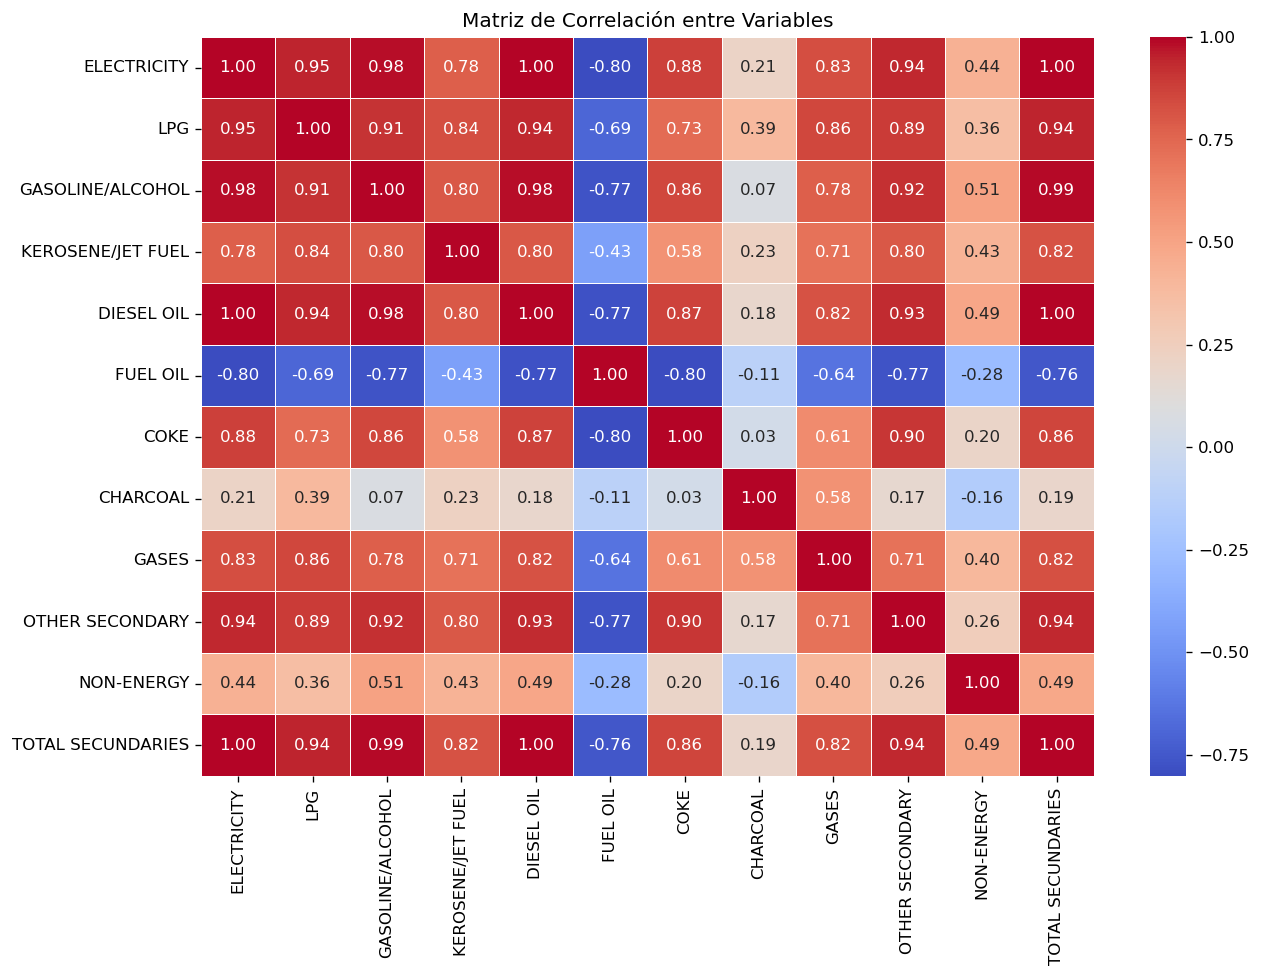

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Eliminar la columna 'SECTOR'
df_TS2.drop(columns='SECTOR', inplace=True)

# Calcular la matriz de correlación
correlation_matrix = df_TS2.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Configurar el título del gráfico
plt.title('Matriz de Correlación entre Variables')

# Mostrar el gráfico
plt.show()



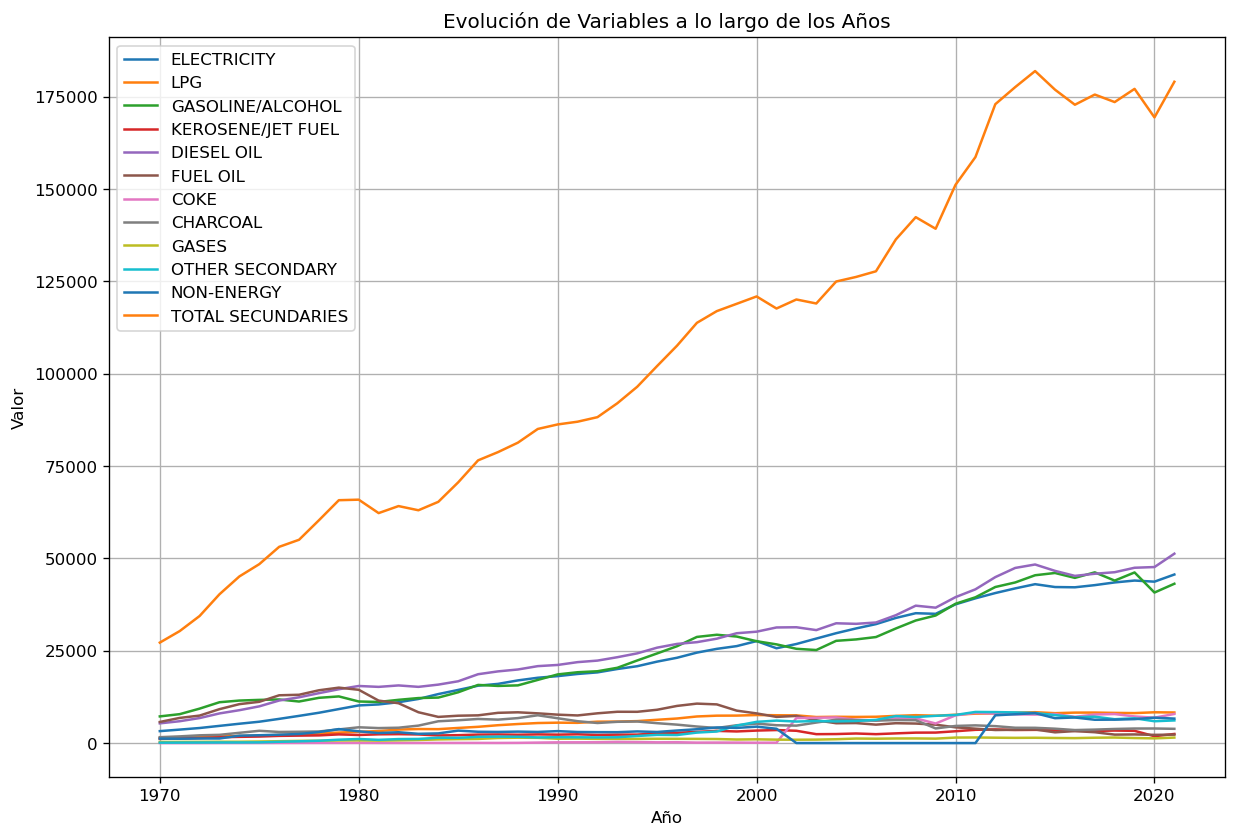

In [54]:
import matplotlib.pyplot as plt

# Variables que deseas graficar
variables = [
    'ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL',
    'FUEL OIL', 'COKE', 'CHARCOAL', 'GASES', 'OTHER SECONDARY', 'NON-ENERGY', 'TOTAL SECUNDARIES'
]

# Crear un gráfico conjunto
plt.figure(figsize=(12, 8))

for variable in variables:
    # Obtener los datos de la variable
    data = df_TS2[variable]
    # Crear una serie temporal
    plt.plot(df_TS2.index, data, label=variable)

# Configurar etiquetas y título
plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Evolución de Variables a lo largo de los Años')
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid(True)
plt.show()


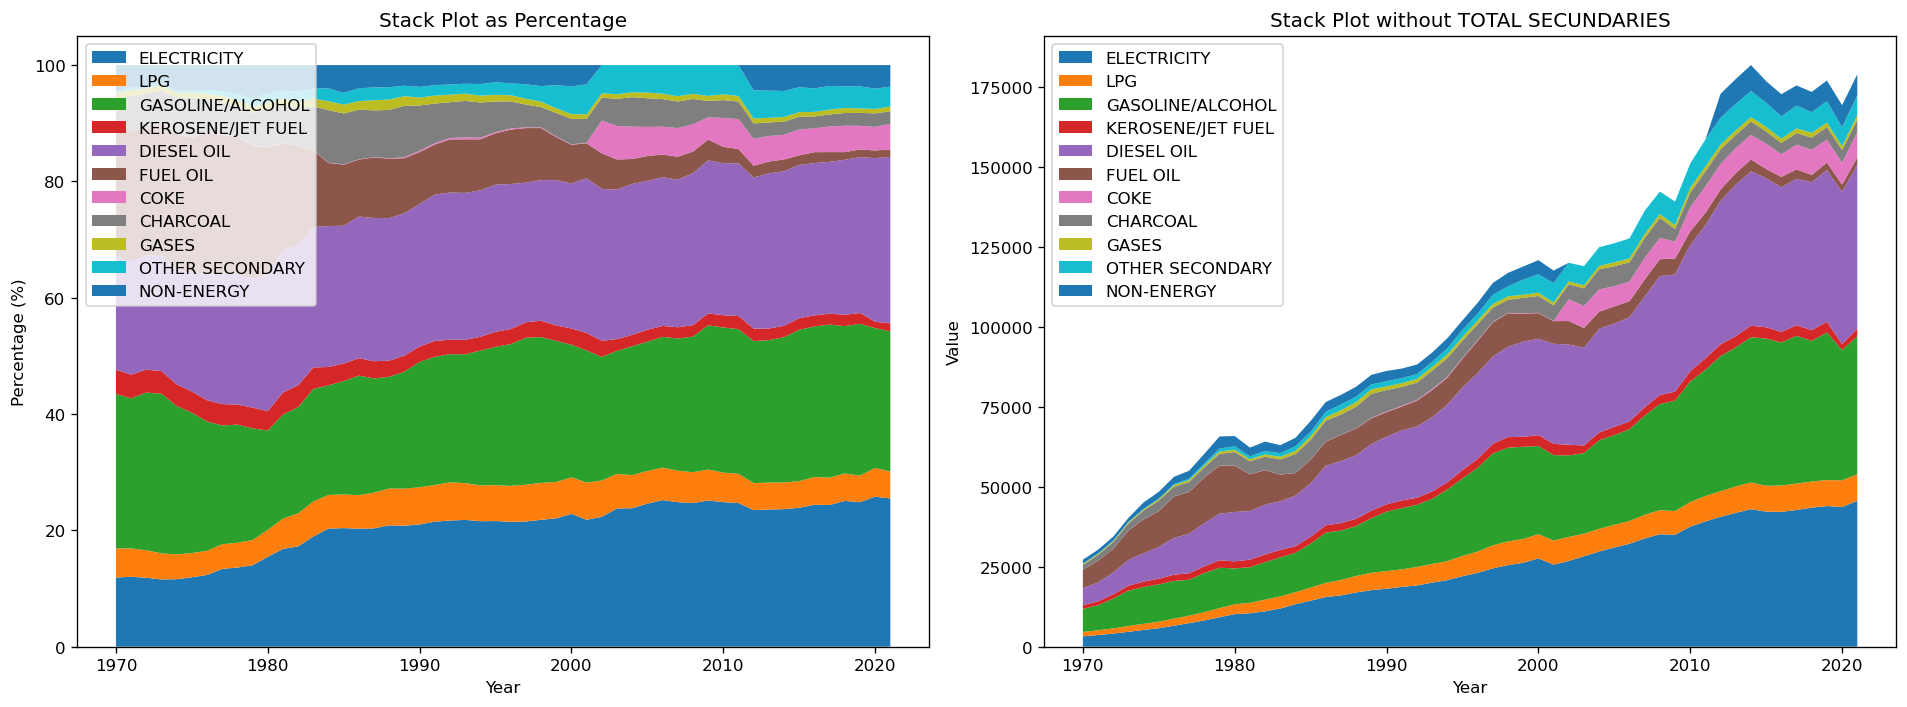

In [55]:
# Data for stack plots (assuming df_TS2 is your DataFrame)
years = df_TS2.index
categories = [
    'ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL',
    'FUEL OIL', 'COKE', 'CHARCOAL', 'GASES', 'OTHER SECONDARY', 'NON-ENERGY'
]

# Create a copy of df_TS2 without the 'TOTAL SECUNDARIES' column
df_no_total = df_TS2.drop(columns='TOTAL SECUNDARIES')

# Calculate percentages for each category relative to the total for each year
percentage_data = df_no_total.div(df_no_total.sum(axis=1), axis=0) * 100

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the stack plot with percentages on the left subplot
ax1.stackplot(years, *[percentage_data[category] for category in categories], labels=categories)
ax1.set_xlabel('Year')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Stack Plot as Percentage')
ax1.legend(loc='upper left')

# Plot the stack plot without 'TOTAL SECUNDARIES' on the right subplot
ax2.stackplot(years, *[df_no_total[category] for category in categories], labels=categories)
ax2.set_xlabel('Year')
ax2.set_ylabel('Value')
ax2.set_title('Stack Plot without TOTAL SECUNDARIES')
ax2.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()




### Running ARIMA

We apply the ARIMA model to all energys, but first, we need to perform some checks to select the best parameters **(p, d, q)**

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
# Split data into train and test sets 
train_size = int(len(df_TS2) * 0.80)

# Separate the data into 2 parts: training and validation
data_tr= df_TS2.iloc[:train_size]
data_val=df_TS2.iloc[train_size:]


### II.1. ELECTRICITY

In [58]:
# Load your energy consumption data for a single energy type
energy_series = df_TS2['GASOLINE/ALCOHOL']
energy_series.head()


YEAR
1970     7219.27
1971     7827.37
1972     9322.37
1973    11056.19
1974    11507.83
Name: GASOLINE/ALCOHOL, dtype: float64

In [59]:
# Train and Test data
df_tr=energy_series.iloc[:train_size]#train[['TRANSPORT']]
df_val=energy_series.iloc[train_size:]

### check stationary of the time series

In [60]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error 

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def MAPE(actual,forecast):
      # Ensure both DataFrames have the same shape
    if actual.shape != forecast.shape:
        raise ValueError("Input data shapes must match.")

    # Replace zero values in y_true with a small non-zero value to avoid division by zero
    actual = actual.replace(0, 1e-10)

    # Calculate the mean of absolute percentage errors 
    mape= round(abs((actual.to_numpy() - forecast.to_numpy()) / actual.to_numpy()).mean()*100,2)

    return mape

import warnings

# Suppress specific warning by category (e.g., FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [61]:
test_stationarity(df_tr)

Results of Dickey-Fuller Test:
Test Statistic                  0.909421
p-value                         0.993212
#Lags Used                      5.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In this case, the p-value is almost  $1$, we can conclude that the data is not stationary.

**The next step, The Partial Autocorrelation Function (PACF) is visualized.**

Showing the PACF is important in time series analysis because it helps in model selection, order determination, diagnosing the adequacy of a chosen model, and understanding the underlying autocorrelation structure of the data. 

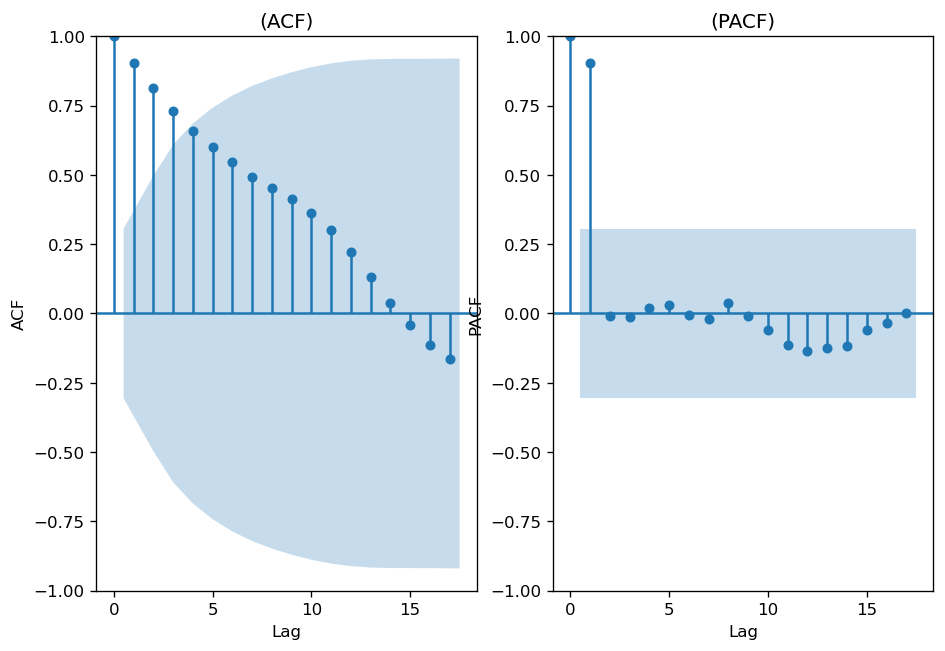

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

# Plot ACF
plot_acf(df_tr, ax=axes[0])
axes[0].set_title('(ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# Plot PACF
plot_pacf(df_tr, ax=axes[1], method='ywm')
axes[1].set_title('(PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.show()

## How to find the order of differencing (d) in ARIMA model

**Transform to stationary: differencing**

In some cases, we  might need to apply differencing to make a time series stationary. If the autocorrelations (ACF) are positive for many number of lags (10 or more), then the series needs further differencing.


<AxesSubplot:xlabel='YEAR'>

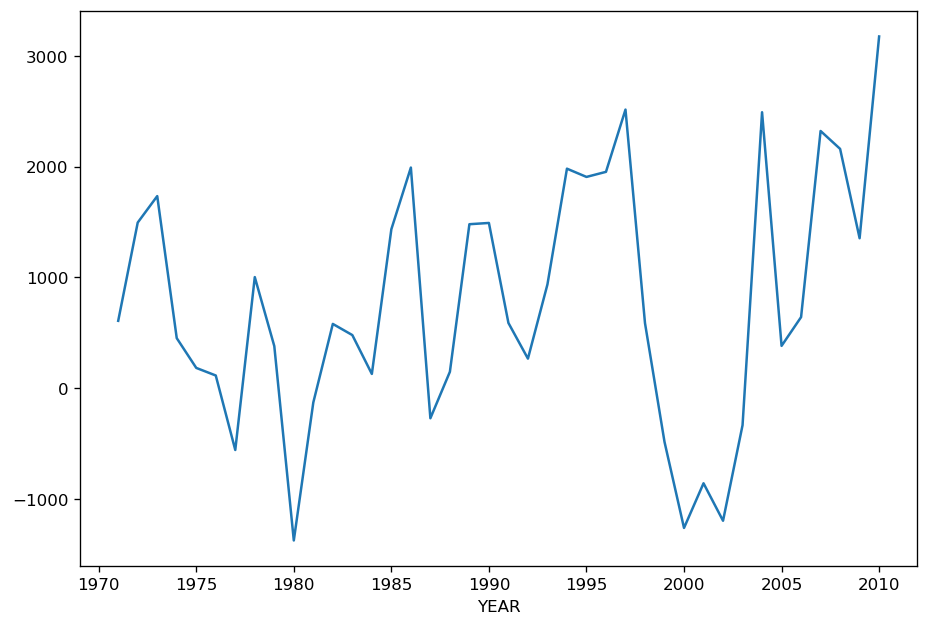

In [63]:
train_diff = df_tr.diff().dropna()
train_diff.plot()

In [64]:
#Test with diffencing data:
test_stationarity(train_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -2.489130
p-value                         0.118142
#Lags Used                      4.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


p-value in the first differential is still greater than 0.05 so the second differential may need.

In [65]:
# Check the second differential:
train_diff_2=df_tr.diff().diff().dropna()
#train_diff_2.plot()

In [66]:
test_stationarity(train_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -7.243812e+00
p-value                        1.854586e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


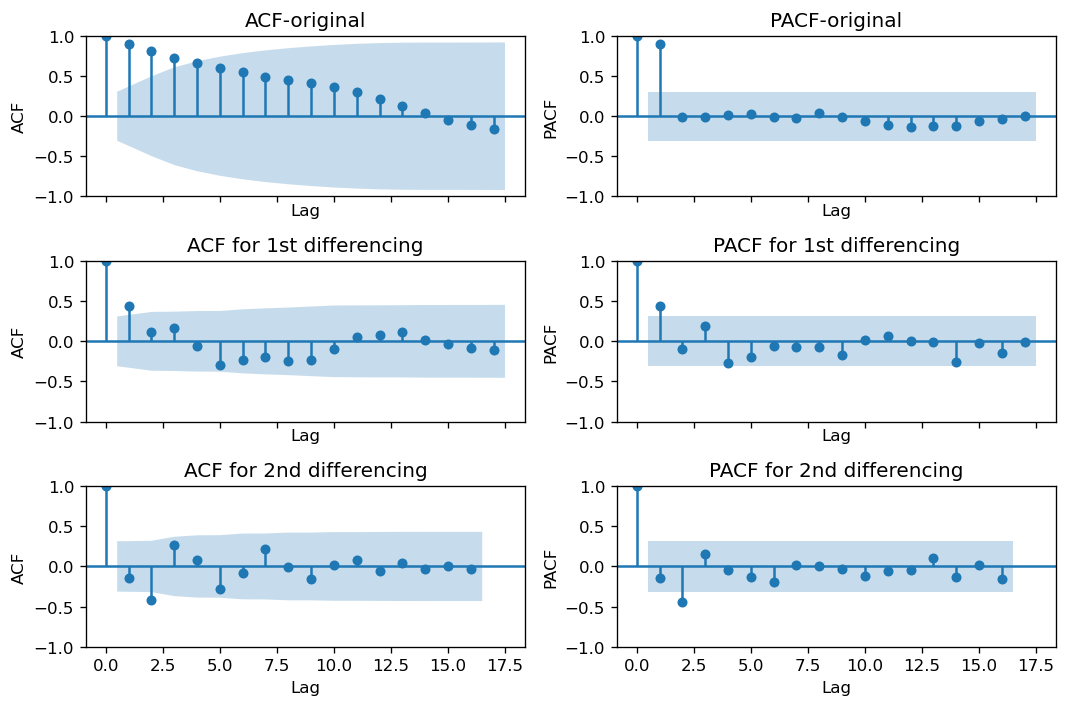

In [67]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (9, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=True)

# Plot ACF for original data
plot_acf(df_tr, ax=axes[0, 0])
axes[0, 0].set_title('ACF-original')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('ACF')

# Plot PACF for train
plot_pacf(df_tr, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF-original')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('PACF')


# Plot ACF for train_diff
plot_acf(train_diff, ax=axes[1, 0])
axes[1, 0].set_title('ACF for 1st differencing')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('ACF')

# Plot PACF for train_diff
plot_pacf(train_diff, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF for 1st differencing')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('PACF')

# Plot ACF for train_diff_2
plot_acf(train_diff_2, ax=axes[2, 0])
axes[2, 0].set_title('ACF for 2nd differencing')
axes[2, 0].set_xlabel('Lag')
axes[2, 0].set_ylabel('ACF')

# Plot PACF for train_diff_2
plot_pacf(train_diff_2, ax=axes[2, 1], method='ywm')
axes[2, 1].set_title('PACF for 2nd differencing')
axes[2, 1].set_xlabel('Lag')
axes[2, 1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

Interpretation of Autocorrelation Function (ACF) Plots:

Stationarity and Differencing (d): I observed that applying a second-order difference (d=2) made the series stationary. This indicates that I need at least two differences to make the series stationary.

Autoregressive Order (p): In the 2nd differencing PACF plot, I see that the first first lag go beyond the blue band and is positive. This suggests a possible value of p=1.

Moving Average Order (q): In the 2nd differencing ACF plot, I notice that up to the first lag go beyond the blue band and are positive. This suggests a possible value of q=1.

In summary, I could start by fitting several ARIMA models with different combinations of p, d, and q, such as ARIMA(2,2,1) or ARIMA(2,1,0)

In [68]:
energy_series.index = pd.to_datetime(energy_series.index, format='%Y')
df_tr.index = pd.to_datetime(df_tr.index, format='%Y')
df_val.index = pd.to_datetime(df_val.index, format='%Y')
df_val.head()

YEAR
2011-01-01    39467.64
2012-01-01    42251.94
2013-01-01    43483.28
2014-01-01    45432.66
2015-01-01    46046.73
Name: GASOLINE/ALCOHOL, dtype: float64

                               SARIMAX Results                                
Dep. Variable:       GASOLINE/ALCOHOL   No. Observations:                   41
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -335.328
Date:                Tue, 12 Sep 2023   AIC                            678.656
Time:                        16:57:05   BIC                            685.411
Sample:                    01-01-1970   HQIC                           681.098
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1544      0.256     -0.603      0.546      -0.656       0.347
ar.L2          0.3201      0.202      1.586      0.113      -0.075       0.716
ma.L1          0.8922      0.225      3.969      0.0

Text(0.5, 1.0, 'GASOLINE/ALCOHOL-MAPE=5.99')

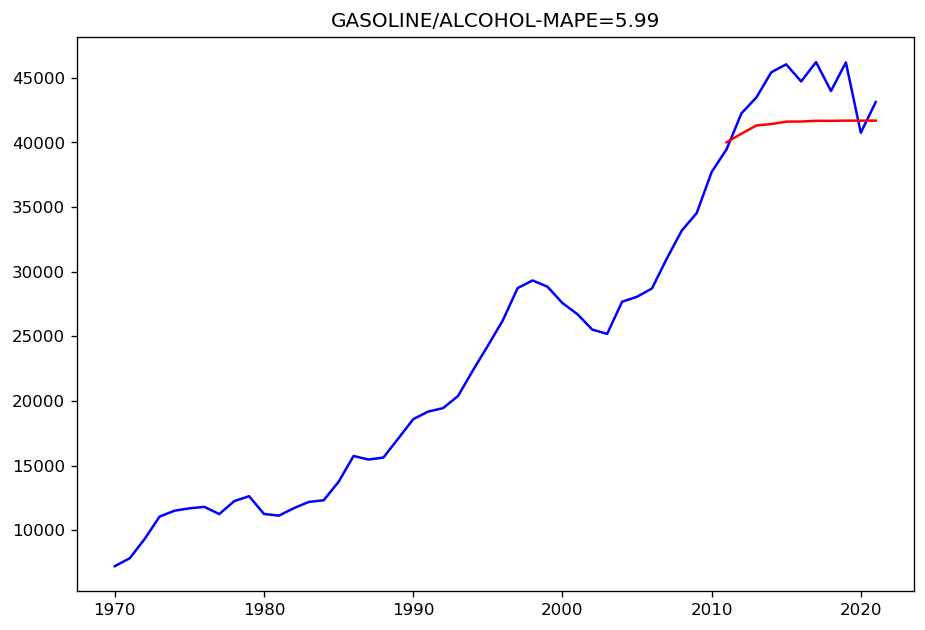

In [69]:
# check with order=(1,2,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(2,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)
df_forecast = df_forecast.squeeze()

#mape=round(mean_absolute_percentage_error(df_val, df_forecast),2)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(energy_series, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f'GASOLINE/ALCOHOL-MAPE={mape}')


                               SARIMAX Results                                
Dep. Variable:       GASOLINE/ALCOHOL   No. Observations:                   41
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -324.102
Date:                Tue, 12 Sep 2023   AIC                            656.203
Time:                        16:57:05   BIC                            662.858
Sample:                    01-01-1970   HQIC                           658.591
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5029      0.534     -0.942      0.346      -1.549       0.543
ar.L2         -0.4339      0.143     -3.044      0.002      -0.713      -0.155
ma.L1          0.3179      0.599      0.530      0.5

Text(0.5, 1.0, 'FUEL OIL-MAPE=23.59')

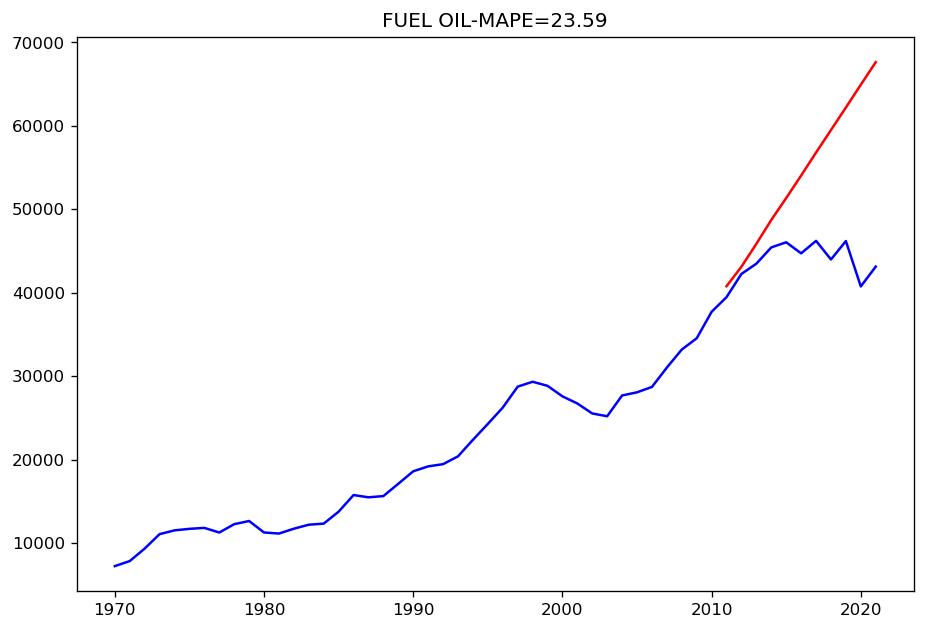

In [70]:
# check with order=(1,2,0)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(2,2,1))
model_fit = model.fit()
print(model_fit.summary())

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)
df_forecast = df_forecast.squeeze()

#mape=round(mean_absolute_percentage_error(df_val, df_forecast),2)
mape=MAPE(df_val, df_forecast)
# Plot

plt.plot(energy_series, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")
plt.title(f'FUEL OIL-MAPE={mape}')

We can observe that 
 returns the better result with MAPE=5.99%

### Future forecast (20 more years)

                               SARIMAX Results                                
Dep. Variable:       GASOLINE/ALCOHOL   No. Observations:                   52
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -440.703
Date:                Tue, 12 Sep 2023   AIC                            889.406
Time:                        16:57:05   BIC                            897.133
Sample:                    01-01-1970   HQIC                           892.359
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0880      0.267      0.330      0.742      -0.435       0.611
ar.L2          0.5338      0.131      4.085      0.000       0.278       0.790
ma.L1         -0.0799      0.328     -0.244      0.8

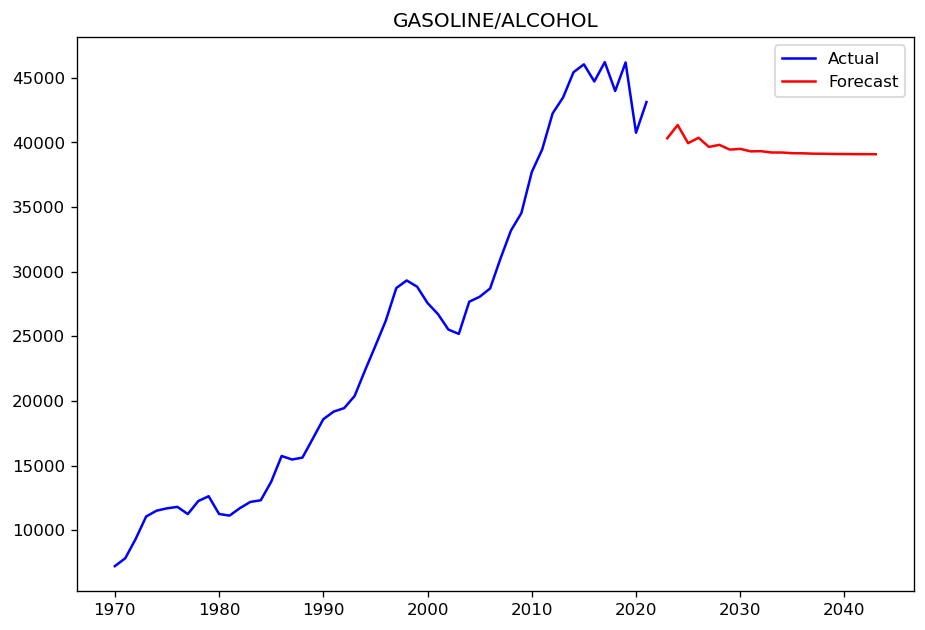

In [71]:
model = ARIMA(energy_series, order=(2,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())
warnings.filterwarnings("ignore")
# Specify the number of future steps to forecast
periods = 20  # Adjust as needed
# Specify the start date
start_date = pd.to_datetime('2022-01-01')

# Prediction for future time points
data_pred = model_fit.predict(start=start_date, end=start_date+ pd.DateOffset(years=periods))


# Create a date range for the forecasted period
forecast_index = date_range = pd.date_range(start=start_date, periods=periods+1, freq='A')

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=list(data_pred), index=forecast_index)

# Plot
plt.plot(energy_series, "b", label="Actual")
plt.plot(df_forecast, "r", label="Forecast")

plt.title("GASOLINE/ALCOHOL")
plt.legend()
plt.show()

df_pred_TRANSPORT=df_forecast
df_pred_TRANSPORT.to_excel("pred_TRANSPORT.xlsx")

In [72]:
df_pred_TRANSPORT

0
2022-12-31  40328.936724
2023-12-31  41350.610470
2024-12-31  39945.396019
2025-12-31  40367.117713
2026-12-31  39654.101310
2027-12-31  39816.474693
2028-12-31  39450.142682
2029-12-31  39504.581278
2030-12-31  39313.817141
2031-12-31  39326.089111
2032-12-31  39225.335558
2033-12-31  39223.019649
2034-12-31  39169.031653
2035-12-31  39163.044106
2036-12-31  39133.697336
2037-12-31  39127.918375
2038-12-31  39111.743923
2039-12-31  39107.235552
2040-12-31  39098.204555
2041-12-31  39095.003118
2042-12-31  39089.900452

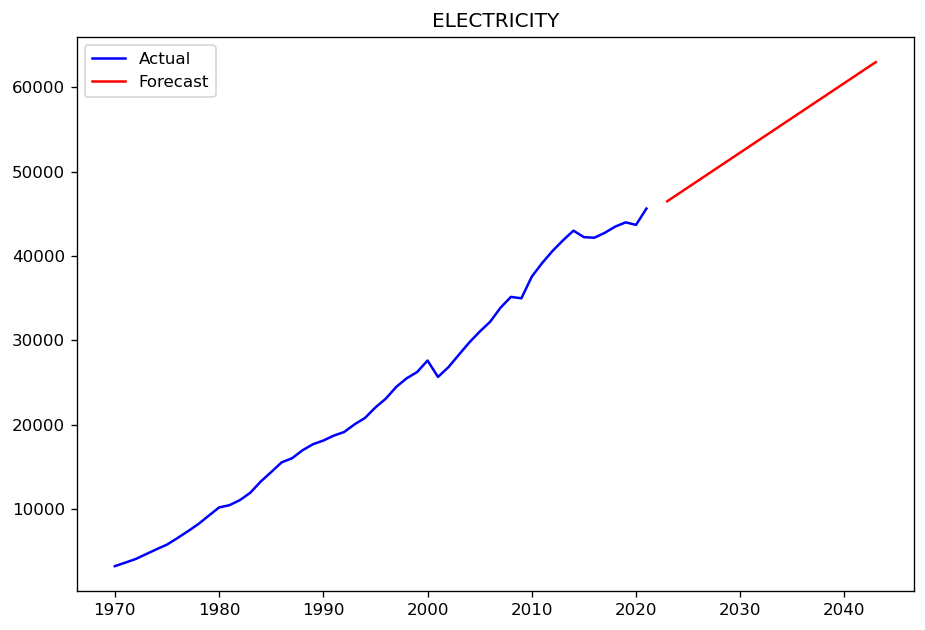

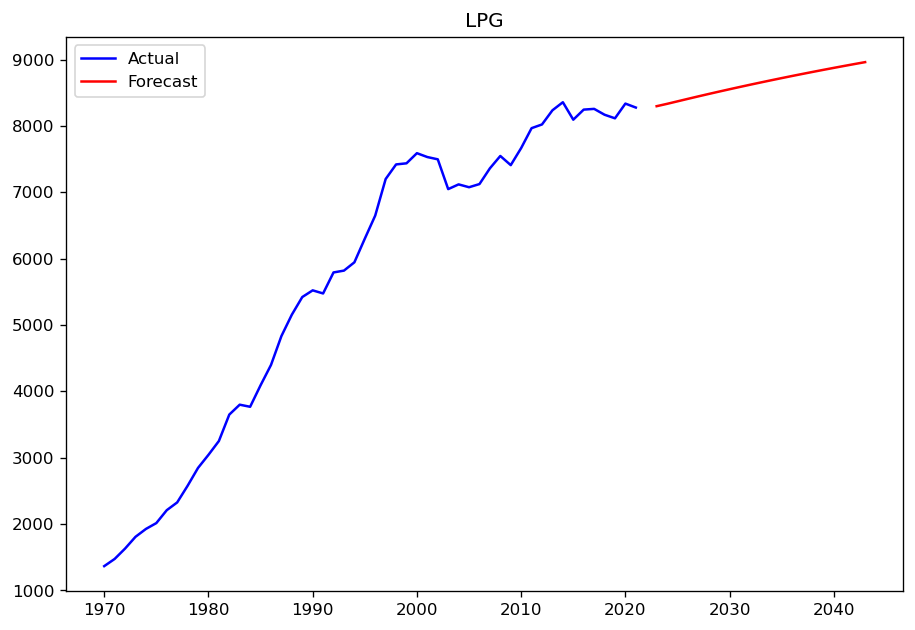

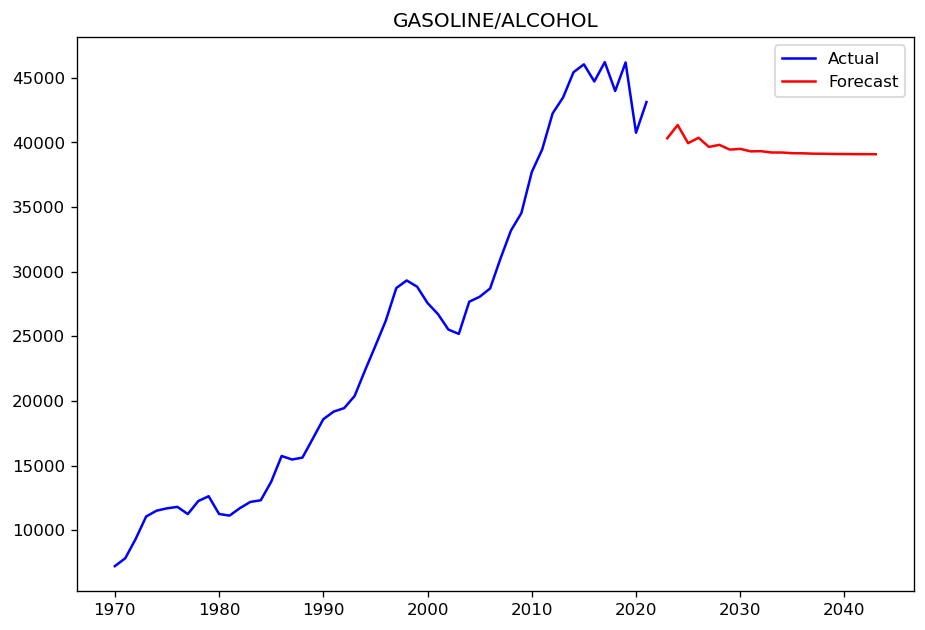

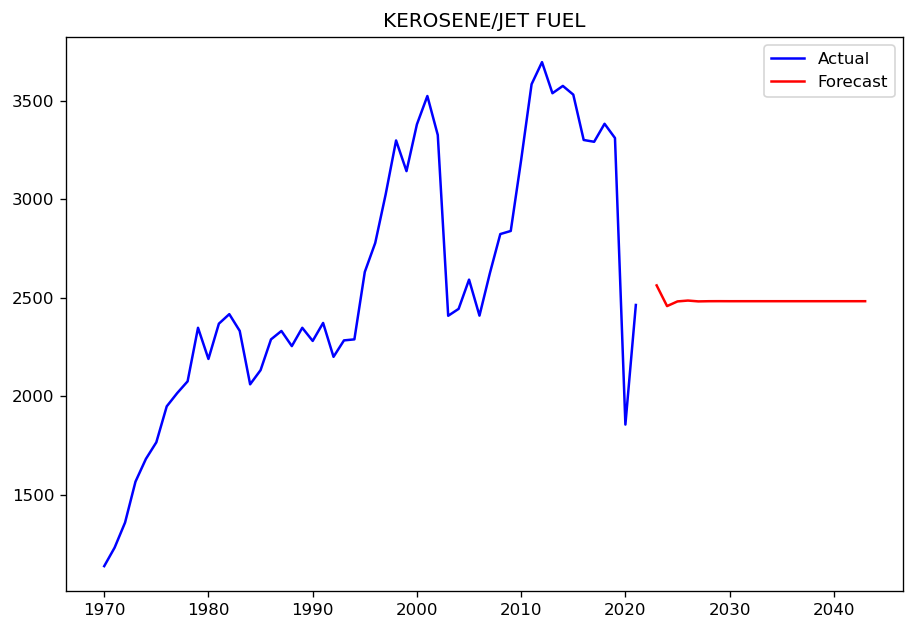

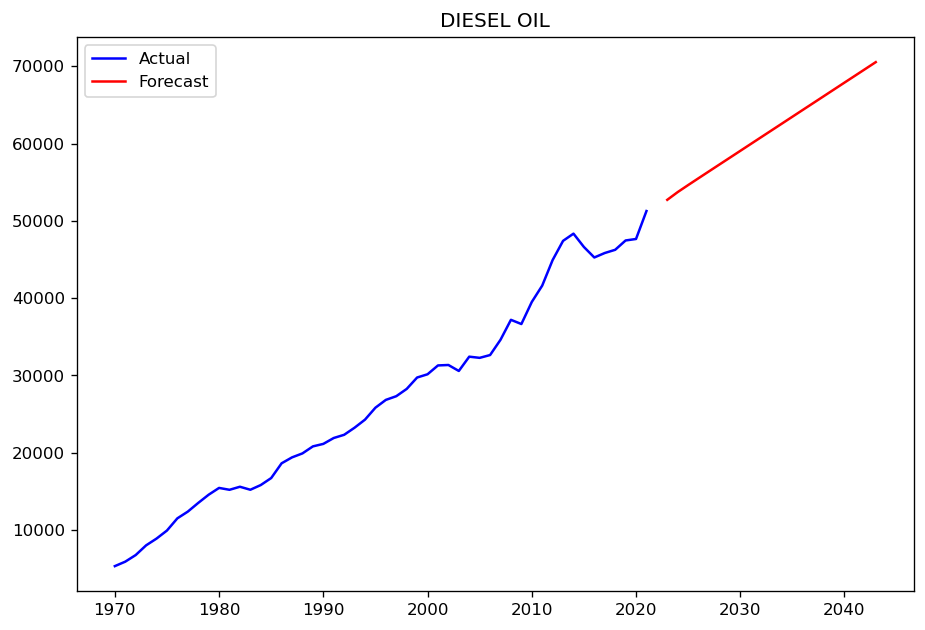

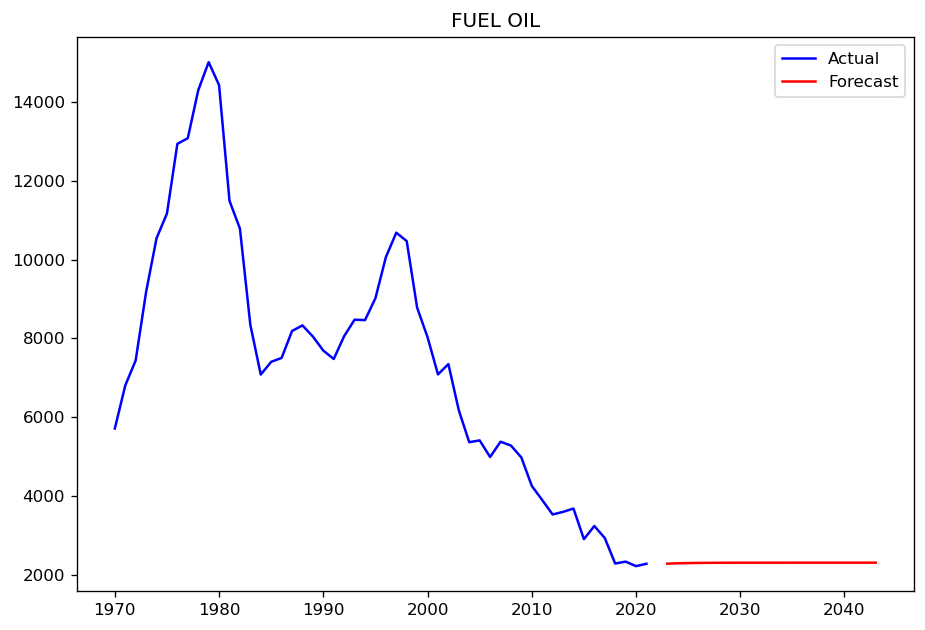

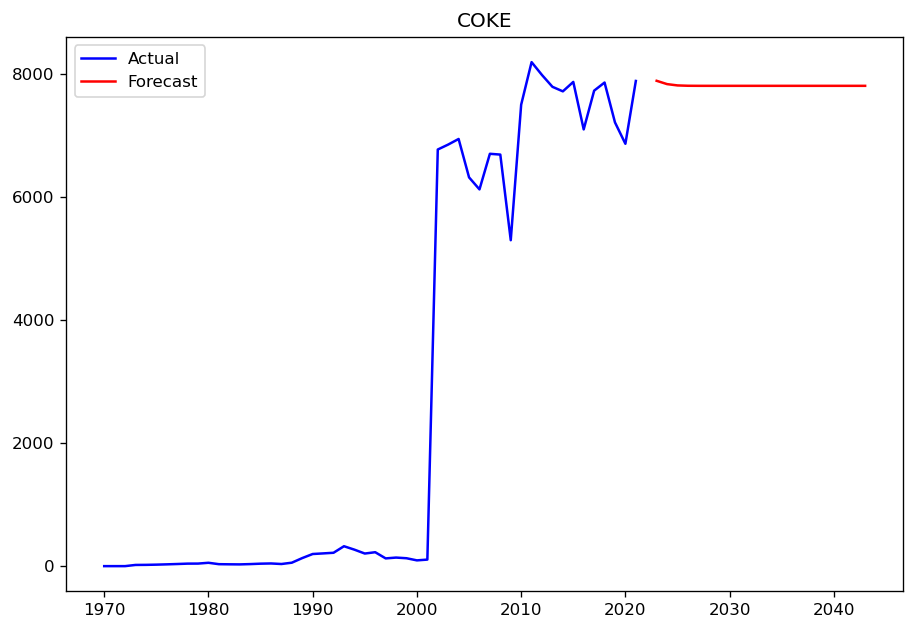

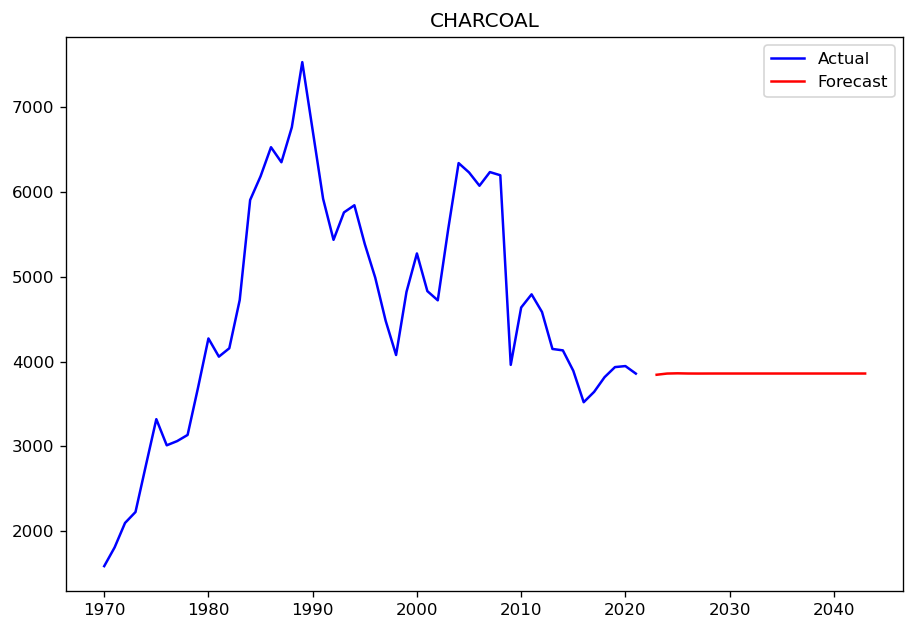

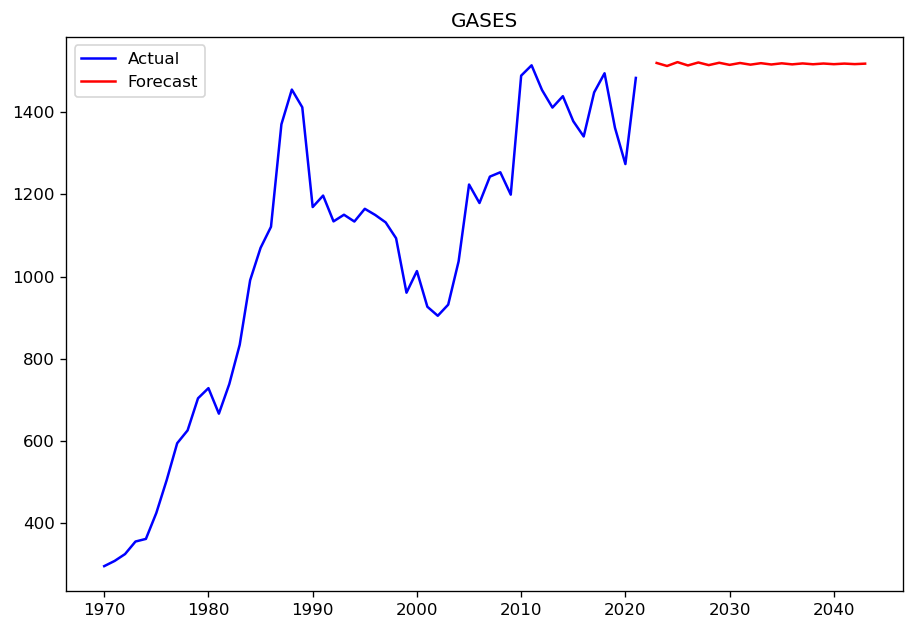

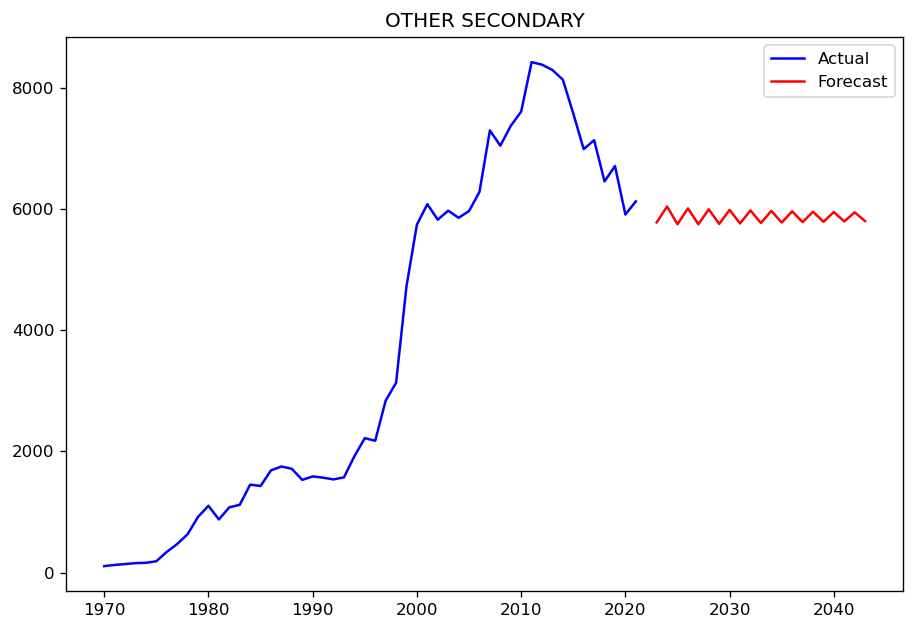

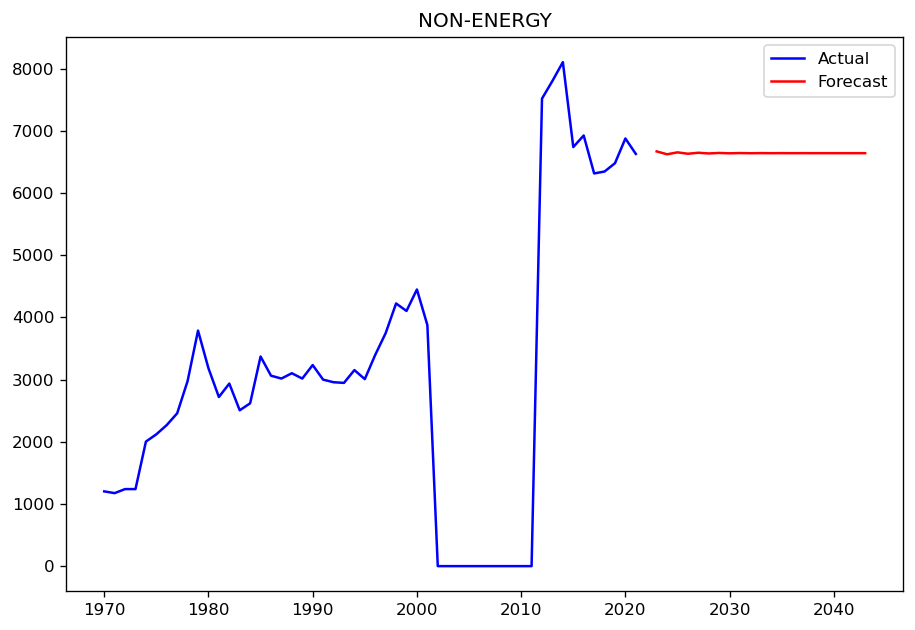

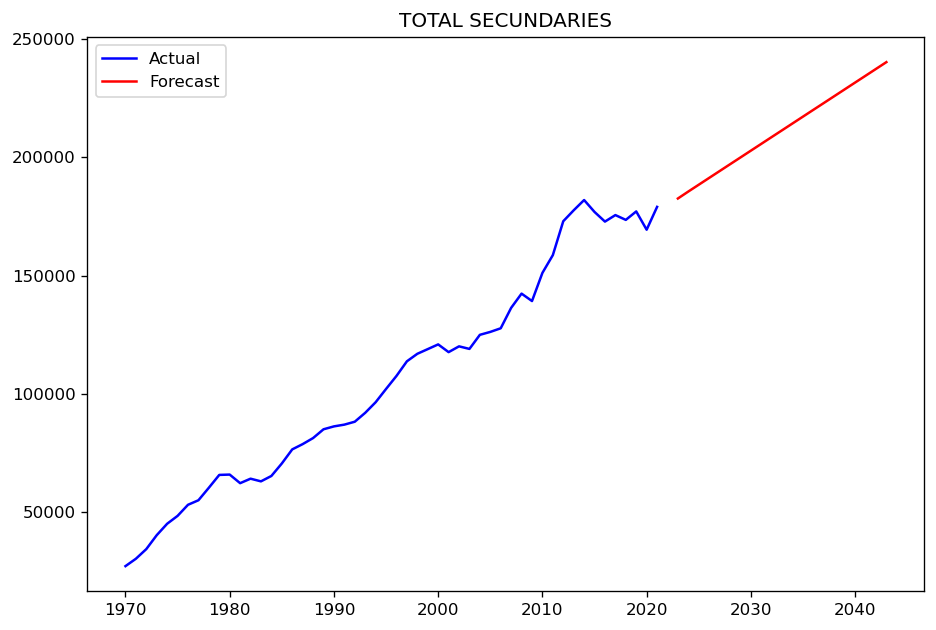

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load your energy consumption data
# Assuming df_TS2 contains all the energy consumption data

df_C_pred = pd.DataFrame()

for s in df_TS2.columns:
    # Select the specific energy column for modeling
    df_sector = df_TS2[[s]]
    df_sector.index = pd.to_datetime(df_sector.index, format='%Y')

    # Build model ARIMA with order=(2,1,1)
    model = ARIMA(df_sector, order=(2, 1, 1))
    model_fit = model.fit()

    # Specify the number of future steps to forecast
    periods = 20  # Adjust as needed
    # Specify the start date
    start_date = pd.to_datetime('2022-01-01')

    # Prediction for future time points
    data_pred = model_fit.predict(start=start_date, end=start_date + pd.DateOffset(years=periods))

    # Create a date range for the forecasted period
    forecast_index = pd.date_range(start=start_date, periods=periods + 1, freq='A')

    # Create a Pandas DataFrame with the forecasted values and set the index
    df_forecast = pd.DataFrame(data=list(data_pred), index=forecast_index, columns=[s])

    # Plot
    plt.plot(df_sector, "b", label="Actual")
    plt.plot(df_forecast, "r", label="Forecast")

    plt.title(f"{s}")
    plt.legend()
    plt.show()

    # Concatenate df
    df_C_pred = pd.concat([df_C_pred, df_forecast], axis=1)
    # Round the values of each column in the dataframe with 2 decimals
    df_C_pred = df_C_pred.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

# Set the index of df_C_pred to be a datetime index
df_C_pred.index = pd.to_datetime(df_C_pred.index, format='%Y')

# Save the df_forecast to excel
file_name = 'df_C_pred.xlsx'
df_C_pred.to_excel(file_name)


## SCENARIOS WITH RENOVABLE SECONDARY ENERGIES

In [74]:
import pandas as pd
import numpy as np

# Cargar los datos originales
df = pd.read_excel('df_C_pred.xlsx', index_col=0)

# Crear un DataFrame vacío para los escenarios
df_scenarios = pd.DataFrame(index=df.index)

# Escenario Optimista: Aumento de energía renovable y disminución de no renovable
percentage_increase_renewable = 0.05  # Aumento del 5% anual en energía renovable
percentage_decrease_non_renewable = 0.02  # Disminución del 2% anual en no renovable

for column in df.columns:
    if column == 'OTHER SECONDARY':  # Energía renovable
        df_scenarios['Optimistic ' + column] = df[column] * (1 + percentage_increase_renewable)  # Aumento anual
    elif column in ['COKE', 'CHARCOAL', 'GASES']:  # Energía no renovable
        df_scenarios['Optimistic ' + column] = df[column] * (1 - percentage_decrease_non_renewable)  # Disminución anual
    else:
        df_scenarios[column] = df[column]  # Mantener otras columnas sin cambios

# Escenario Pesimista: Aumento de no renovable y disminución de renovable
percentage_increase_non_renewable = 0.02  # Aumento del 2% anual en no renovable
percentage_decrease_renewable = 0.05  # Disminución del 5% anual en renovable

for column in df.columns:
    if column == 'OTHER SECONDARY':  # Energía renovable
        df_scenarios['Pessimistic ' + column] = df[column] * (1 - percentage_decrease_renewable)  # Disminución anual
    elif column in ['COKE', 'CHARCOAL', 'GASES']:  # Energía no renovable
        df_scenarios['Pessimistic ' + column] = df[column] * (1 + percentage_increase_non_renewable)  # Aumento anual
    else:
        df_scenarios[column] = df[column]  # Mantener otras columnas sin cambios

# Exportar los resultados a un archivo de Excel
df_scenarios.to_excel('energy_scenarios.xlsx')


In [75]:
import pandas as pd

# Load the forecasted energy consumption data
df_C_pred = pd.read_excel('df_C_pred.xlsx', index_col=0)

# Define the growth rate for the optimistic scenario (5% cumulative increase)
growth_rate_optimistic = 0.05

# Calculate the cumulative increase in OTHER SECONDARY for the optimistic scenario
total_increase_optimistic = (1 + growth_rate_optimistic) ** (2040 - 2022) - 1

# Calculate the amount to subtract from COKE, CHARCOAL, and GASES for the optimistic scenario
df_C_pred['COKE'] -= (df_C_pred['OTHER SECONDARY'] / total_increase_optimistic) * total_increase_optimistic
df_C_pred['CHARCOAL'] -= (df_C_pred['OTHER SECONDARY'] / total_increase_optimistic) * total_increase_optimistic
df_C_pred['GASES'] -= (df_C_pred['OTHER SECONDARY'] / total_increase_optimistic) * total_increase_optimistic

# Calculate the cumulative decrease in OTHER SECONDARY for the pessimistic scenario (5% cumulative decrease)
growth_rate_pessimistic = -0.05
total_decrease_pessimistic = (1 + growth_rate_pessimistic) ** (2040 - 2022) - 1

# Calculate the amount to add to COKE, CHARCOAL, and GASES for the pessimistic scenario
df_C_pred['COKE'] += (df_C_pred['OTHER SECONDARY'] / total_decrease_pessimistic) * total_decrease_pessimistic
df_C_pred['CHARCOAL'] += (df_C_pred['OTHER SECONDARY'] / total_decrease_pessimistic) * total_decrease_pessimistic
df_C_pred['GASES'] += (df_C_pred['OTHER SECONDARY'] / total_decrease_pessimistic) * total_decrease_pessimistic

# Now, df_C_pred contains the energy consumption values for the optimistic and pessimistic scenarios
# You can save these scenarios to separate Excel files or analyze them further as needed






In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming df_TS2 contains all the energy consumption data

# Define the variables for the scenarios
variables = ['OTHER SECONDARY', 'COKE', 'CHARCOAL', 'GASES']

# Create DataFrames to store the forecasts for both scenarios
df_optimistic_forecasts = pd.DataFrame()
df_pessimistic_forecasts = pd.DataFrame()

for variable in variables:
    # Select the specific energy column for modeling
    df_sector = df_TS2[[variable]]
    df_sector.index = pd.to_datetime(df_sector.index, format='%Y')

    # Build model ARIMA with order=(2,1,1)
    model = ARIMA(df_sector, order=(2, 1, 1))
    model_fit = model.fit()

    # Specify the number of future steps to forecast
    periods = 19  # Forecasting from 2022 to 2040 (19 years)
    start_date = pd.to_datetime('2022-01-01')

    # Generate forecasts for both scenarios
    optimistic_forecasts = [df_sector.iloc[-1].values[0]]  # Initialize with the last known value (2021)
    pessimistic_forecasts = [df_sector.iloc[-1].values[0]]  # Initialize with the last known value (2021)

    for year in range(2022, 2041):  # Forecasting from 2022 to 2040
        if variable == 'OTHER SECONDARY':
            # Optimistic scenario: Increase OTHER SECONDARY, decrease COKE, CHARCOAL, and GASES
            optimistic_value = optimistic_forecasts[-1] + 80  # Adjust the increase as needed
            pessimistic_value = pessimistic_forecasts[-1] - 40  # Adjust the decrease as needed
        else:
            # Optimistic scenario: Decrease COKE, CHARCOAL, and GASES, increase OTHER SECONDARY
            optimistic_value = optimistic_forecasts[-1] - 60  # Adjust the decrease as needed
            pessimistic_value = pessimistic_forecasts[-1] + 30  # Adjust the increase as needed

        # Append the forecast for the year
        optimistic_forecasts.append(optimistic_value)
        pessimistic_forecasts.append(pessimistic_value)

    # Create a date range for the forecasted period (2022 to 2040, 19 years)
    forecast_index = pd.date_range(start=start_date, periods=periods + 1, freq='A')

    # Create DataFrames with the forecasted values and set the column names
    df_optimistic_forecast = pd.DataFrame(data=optimistic_forecasts, index=forecast_index, columns=[variable])
    df_pessimistic_forecast = pd.DataFrame(data=pessimistic_forecasts, index=forecast_index, columns=[variable])

    # Concatenate the forecasts to the respective DataFrames
    df_optimistic_forecasts = pd.concat([df_optimistic_forecasts, df_optimistic_forecast], axis=1)
    df_pessimistic_forecasts = pd.concat([df_pessimistic_forecasts, df_pessimistic_forecast], axis=1)

# Round the values of the resulting DataFrames with 2 decimal places
df_optimistic_forecasts = df_optimistic_forecasts.round(2)
df_pessimistic_forecasts = df_pessimistic_forecasts.round(2)

# Save the forecasts to excel for both scenarios
file_name_optimistic = 'optimistic_energy_forecasts.xlsx'
df_optimistic_forecasts.to_excel(file_name_optimistic)

file_name_pessimistic = 'pessimistic_energy_forecasts.xlsx'
df_pessimistic_forecasts.to_excel(file_name_pessimistic)



In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming df_TS2 contains all the energy consumption data

# Define the variables for the scenarios
variables = ['OTHER SECONDARY', 'COKE', 'CHARCOAL', 'GASES', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL', 'FUEL OIL']

# Create DataFrames to store the forecasts for both scenarios
df_optimistic_forecasts = pd.DataFrame()
df_pessimistic_forecasts = pd.DataFrame()

for variable in variables:
    # Select the specific energy column for modeling
    df_sector = df_TS2[[variable]]
    df_sector.index = pd.to_datetime(df_sector.index, format='%Y')

    # Build model ARIMA with order=(2,1,1)
    model = ARIMA(df_sector, order=(2, 1, 1))
    model_fit = model.fit()

    # Specify the number of future steps to forecast
    periods = 19  # Forecasting from 2022 to 2040 (19 years)
    start_date = pd.to_datetime('2022-01-01')

    # Generate forecasts for both scenarios
    optimistic_forecasts = [df_sector.iloc[-1].values[0]]  # Initialize with the last known value (2021)
    pessimistic_forecasts = [df_sector.iloc[-1].values[0]]  # Initialize with the last known value (2021)

    for year in range(2022, 2041):  # Forecasting from 2022 to 2040
        if variable == 'OTHER SECONDARY':
            # Optimistic scenario: Increase OTHER SECONDARY
            optimistic_value = optimistic_forecasts[-1] + 0.05 * total_consumption  # Adjust the factor as needed
            pessimistic_value = pessimistic_forecasts[-1] -  0.05 * total_consumption  # Adjust the factor as needed
        elif variable in ['COKE', 'CHARCOAL', 'GASES']:
            # Optimistic scenario: Decrease COKE, CHARCOAL, and GASES in greater extent
            optimistic_value = optimistic_forecasts[-1] -  0.05 * total_consumption  # Adjust the factor as needed
            pessimistic_value = pessimistic_forecasts[-1] +  0.05 * total_consumption  # Adjust the factor as needed
        else:
            # Optimistic scenario: Decrease other variables in lesser extent
            optimistic_value = optimistic_forecasts[-1] -  0.05 * total_consumption  # Adjust the factor as needed
            pessimistic_value = pessimistic_forecasts[-1] +  0.05 * total_consumption  # Adjust the factor as needed

        # Append the forecast for the year
        optimistic_forecasts.append(optimistic_value)
        pessimistic_forecasts.append(pessimistic_value)

    # Create a date range for the forecasted period (2022 to 2040, 19 years)
    forecast_index = pd.date_range(start=start_date, periods=periods + 1, freq='A')

    # Create DataFrames with the forecasted values and set the column names
    df_optimistic_forecast = pd.DataFrame(data=optimistic_forecasts, index=forecast_index, columns=[variable])
    df_pessimistic_forecast = pd.DataFrame(data=pessimistic_forecasts, index=forecast_index, columns=[variable])

    # Concatenate the forecasts to the respective DataFrames
    df_optimistic_forecasts = pd.concat([df_optimistic_forecasts, df_optimistic_forecast], axis=1)
    df_pessimistic_forecasts = pd.concat([df_pessimistic_forecasts, df_pessimistic_forecast], axis=1)

# Round the values of the resulting DataFrames with 2 decimal places
df_optimistic_forecasts = df_optimistic_forecasts.round(2)
df_pessimistic_forecasts = df_pessimistic_forecasts.round(2)

# Save the forecasts to excel for both scenarios
file_name_optimistic = 'optimistic_energy_forecasts.xlsx'
df_optimistic_forecasts.to_excel(file_name_optimistic)

file_name_pessimistic = 'pessimistic_energy_forecasts.xlsx'
df_pessimistic_forecasts.to_excel(file_name_pessimistic)



NameError: name 'total_consumption' is not defined

In [ ]:
import pandas as pd

# Carga el DataFrame con las predicciones
df_pred = pd.read_excel('df_C_pred.xlsx', index_col=0)

# Escenario optimista: Aumento del 10% en OTHER SECONDARY a costa de otras energías
optimistic_scenario = df_pred.copy()

# Aumento del 10% en OTHER SECONDARY
increase_percent = 0.10
optimistic_scenario['OTHER SECONDARY'] = optimistic_scenario['OTHER SECONDARY'] * (1 + increase_percent)

# Actualiza las demás energías
# Por ejemplo, distribución uniforme de la reducción en otras energías
total_energy_increase = optimistic_scenario['OTHER SECONDARY'] - df_pred['OTHER SECONDARY']
energies_to_reduce = ['ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL', 'FUEL OIL', 'COKE', 'CHARCOAL', 'GASES']
share_per_energy = total_energy_increase / len(energies_to_reduce)

for energy in energies_to_reduce:
    optimistic_scenario[energy] -= share_per_energy
# Escenario pesimista: Reducción en COKE, CHARCOAL y GASES a costa de OTHER SECONDARY y otras energías
pessimistic_scenario = df_pred.copy()

# Reducción en COKE, CHARCOAL y GASES
decrease_percent = 0.10  # Puedes ajustar esto según tu escenario
pessimistic_scenario['COKE'] = pessimistic_scenario['COKE'] * (1 - decrease_percent)
pessimistic_scenario['CHARCOAL'] = pessimistic_scenario['CHARCOAL'] * (1 - decrease_percent)
pessimistic_scenario['GASES'] = pessimistic_scenario['GASES'] * (1 - decrease_percent)

# Actualiza OTHER SECONDARY
total_energy_decrease = df_pred['COKE'] + df_pred['CHARCOAL'] + df_pred['GASES'] - pessimistic_scenario['COKE'] - pessimistic_scenario['CHARCOAL'] - pessimistic_scenario['GASES']
pessimistic_scenario['OTHER SECONDARY'] -= total_energy_decrease

# Actualiza otras energías
# Por ejemplo, redistribuye uniformemente el aumento de OTHER SECONDARY
total_energy_increase = df_pred['OTHER SECONDARY'] - pessimistic_scenario['OTHER SECONDARY']
energies_to_increase = ['ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL', 'FUEL OIL']
share_per_energy = total_energy_increase / len(energies_to_increase)

for energy in energies_to_increase:
    pessimistic_scenario[energy] += share_per_energy
    
# Exporta el escenario optimista a un archivo Excel
optimistic_scenario.to_excel('optimistic_scenario.xlsx')

# Exporta el escenario pesimista a un archivo Excel
pessimistic_scenario.to_excel('pessimistic_scenario.xlsx')


In [ ]:
import pandas as pd

# Carga el DataFrame con las predicciones
df_pred = pd.read_excel('df_C_pred.xlsx', index_col=0)

# Escenario optimista: Aumento del 10% en OTHER SECONDARY a costa de otras energías
optimistic_scenario = df_pred.copy()

# Escenario pesimista: Reducción en COKE, CHARCOAL y GASES a costa de OTHER SECONDARY y otras energías
pessimistic_scenario = df_pred.copy()

# Aumento del 10% en OTHER SECONDARY en el escenario optimista
increase_percent = 0.10
optimistic_scenario['OTHER SECONDARY'] = optimistic_scenario['OTHER SECONDARY'] * (1 + increase_percent)

# Reducción en COKE, CHARCOAL y GASES en el escenario pesimista
decrease_percent = 0.10  # Puedes ajustar esto según tu escenario
pessimistic_scenario['COKE'] = pessimistic_scenario['COKE'] * (1 - decrease_percent)
pessimistic_scenario['CHARCOAL'] = pessimistic_scenario['CHARCOAL'] * (1 - decrease_percent)
pessimistic_scenario['GASES'] = pessimistic_scenario['GASES'] * (1 - decrease_percent)

# Aumento en OTHER SECONDARY en el escenario optimista y redistribución uniforme en el pesimista
total_energy_increase_optimistic = optimistic_scenario['OTHER SECONDARY'] - df_pred['OTHER SECONDARY']
total_energy_decrease_pessimistic = df_pred['COKE'] + df_pred['CHARCOAL'] + df_pred['GASES'] - pessimistic_scenario['COKE'] - pessimistic_scenario['CHARCOAL'] - pessimistic_scenario['GASES']

# Actualiza las demás energías en ambos escenarios
energies_to_reduce = ['ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL', 'FUEL OIL']
energies_to_increase = ['ELECTRICITY', 'LPG', 'GASOLINE/ALCOHOL', 'KEROSENE/JET FUEL', 'DIESEL OIL', 'FUEL OIL']

for energy in energies_to_reduce:
    optimistic_scenario[energy] -= total_energy_increase_optimistic / len(energies_to_reduce)
    pessimistic_scenario[energy] -= total_energy_decrease_pessimistic / len(energies_to_reduce)

for energy in energies_to_increase:
    optimistic_scenario[energy] += total_energy_increase_optimistic / len(energies_to_increase)
    pessimistic_scenario[energy] += total_energy_decrease_pessimistic / len(energies_to_increase)

# Exporta el escenario optimista a un archivo Excel
optimistic_scenario.to_excel('optimistic_scenario.xlsx')

# Exporta el escenario pesimista a un archivo Excel
pessimistic_scenario.to_excel('pessimistic_scenario.xlsx')


In [ ]:
import pandas as pd

# Cargar el DataFrame original
df_original = df_TS2

# Cargar el DataFrame de pronóstico
df_forecast = pd.read_excel('df_C_pred.xlsx', index_col=0)

# Definir las tasas de aumento y reducción iniciales para cada categoría
tasas_optimista_iniciales = {
    'OTHER SECONDARY': 0.04,
    'COKE': -0.01,
    'CHARCOAL': -0.01,
    'GASES': -0.01,
    'ELECTRICITY': 0.01,
    'LPG': -0.01,
    'GASOLINE/ALCOHOL': -0.015,
    'KEROSENE/JET FUEL': -0.015,
    'DIESEL OIL': -0.015,
    'FUEL OIL': -0.015,
    'NON-ENERGY': 0.0
}

tasas_pesimista_iniciales = {
    'COKE': 0.02,
    'CHARCOAL': 0.01,
    'GASES': 0.03,
    'OTHER SECONDARY': -0.04,
    'ELECTRICITY': 0.01,
    'LPG': -0.02,
    'GASOLINE/ALCOHOL': -0.015,
    'KEROSENE/JET FUEL': -0.015,
    'DIESEL OIL': -0.015,
    'FUEL OIL': -0.015,
    'NON-ENERGY': 0.0
}

# Crear un DataFrame para los escenarios optimistas y pesimistas
df_optimista = df_forecast.copy()
df_pesimista = df_forecast.copy()

# Calcular los valores para los escenarios optimistas
for columna in df_forecast.columns:
    if columna in tasas_optimista_iniciales:
        tasa = 1.0 + tasas_optimista_iniciales[columna]
        for i in range(1, len(df_forecast)):
            df_optimista[columna].iloc[i] = df_optimista[columna].iloc[i - 1] * tasa

# Calcular los valores para los escenarios pesimistas
for columna in df_forecast.columns:
    if columna in tasas_pesimista_iniciales:
        tasa = 1.0 + tasas_pesimista_iniciales[columna]
        for i in range(1, len(df_forecast)):
            df_pesimista[columna].iloc[i] = df_pesimista[columna].iloc[i - 1] * tasa

# Guardar los resultados en archivos Excel
df_optimista.to_excel('escenario_optimista_acumulado.xlsx')
df_pesimista.to_excel('escenario_pesimista_acumulado.xlsx')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  # Import ARIMA from the new location
import warnings
warnings.filterwarnings("ignore")


# Define the initial growth rates for each energy category in both scenarios
tasas_optimista_iniciales = {
    'OTHER SECONDARY': 1.06,
    'COKE': 0.95,
    'CHARCOAL': 0.95,
    'GASES': 0.95,
    'ELECTRICITY': 1.0,
    'LPG': 1.0,
    'GASOLINE/ALCOHOL': 0.98,
    'KEROSENE/JET FUEL': 0.98,
    'DIESEL OIL': 0.98,
    'FUEL OIL': 0.98,
    'NON-ENERGY': 1.0
}

tasas_pesimista_iniciales = {
    'COKE': 1.10,
    'CHARCOAL': 1.10,
    'GASES': 1.10,
    'OTHER SECONDARY': 0.85,
    'ELECTRICITY': 0.95,
    'LPG': 0.95,
    'GASOLINE/ALCOHOL': 0.95,
    'KEROSENE/JET FUEL': 0.95,
    'DIESEL OIL': 0.95,
    'FUEL OIL': 0.95,
    'NON-ENERGY': 1.0
}

# Create DataFrames to store the results
df_C_pred_optimistic = pd.DataFrame()
df_C_pred_pessimistic = pd.DataFrame()

# Specify the number of future years to forecast
years_to_forecast = 2040 - 2022 + 1

# Loop through each sector
for s in df_TS2.columns:
    # Prepare data
    df_sector = df_TS2[[s]]
    df_sector.index = pd.to_datetime(df_sector.index, format='%Y')

    # Build ARIMA model with order=(2,1,1)
    model = ARIMA(df_sector, order=(2, 1, 1))
    model_fit = model.fit()

    # Calculate the cumulative growth factors for both scenarios
    growth_optimistic = [tasas_optimista_iniciales[s] ** i for i in range(1, years_to_forecast + 1)]
    growth_pessimistic = [tasas_pesimista_iniciales[s] ** i for i in range(1, years_to_forecast + 1)]

    # Specify the start date for the forecast
    start_date = pd.to_datetime('2022-01-01')

    # Make predictions for both scenarios
    data_pred_optimistic = model_fit.predict(start=start_date, end=start_date + pd.DateOffset(years=years_to_forecast))
    data_pred_pessimistic = model_fit.predict(start=start_date, end=start_date + pd.DateOffset(years=years_to_forecast))

    # Apply cumulative growth factors to the predictions
    data_pred_optimistic *= growth_optimistic
    data_pred_pessimistic *= growth_pessimistic

    # Create date ranges for the forecasted periods
    forecast_index = pd.date_range(start=start_date, periods=years_to_forecast + 1, freq='A')

    # Create DataFrames with the forecasted values and set the index
    df_forecast_optimistic = pd.DataFrame(data=list(data_pred_optimistic), index=forecast_index, columns=[s])
    df_forecast_pessimistic = pd.DataFrame(data=list(data_pred_pessimistic), index=forecast_index, columns=[s])

    # Concatenate DataFrames for both scenarios
    df_C_pred_optimistic = pd.concat([df_C_pred_optimistic, df_forecast_optimistic], axis=1)
    df_C_pred_pessimistic = pd.concat([df_C_pred_pessimistic, df_forecast_pessimistic], axis=1)

# Round the values of each column in the DataFrames with 2 decimals
df_C_pred_optimistic = df_C_pred_optimistic.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)
df_C_pred_pessimistic = df_C_pred_pessimistic.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

# Set the index of the DataFrames to be the year
df_C_pred_optimistic.index = df_C_pred_optimistic.index.year
df_C_pred_pessimistic.index = df_C_pred_pessimistic.index.year

# Save the DataFrames to Excel files
df_C_pred_optimistic.to_excel('df_C_pred_optimistic.xlsx')
df_C_pred_pessimistic.to_excel('df_C_pred_pessimistic.xlsx')


In [ ]:
# Guardar el DataFrame df_optimista en un archivo Excel
df_optimista.to_excel('df_optimista.xlsx')

# Guardar el DataFrame df_pesimista en un archivo Excel
df_pesimista.to_excel('df_pesimista.xlsx')


In [ ]:
df_TS2

In [ ]:
import pandas as pd

# Cargar el DataFrame original
df_original = df_TS2

# Cargar el DataFrame de pronóstico
df_forecast = pd.read_excel('df_C_pred.xlsx', index_col=0)

tasas_optimista_iniciales = {
    'OTHER SECONDARY': 1.06,
    'COKE': 0.95,
    'CHARCOAL': 0.95,
    'GASES': 0.95,
    'ELECTRICITY': 1.0,
    'LPG': 1.0,
    'GASOLINE/ALCOHOL': 0.98,
    'KEROSENE/JET FUEL': 0.98,
    'DIESEL OIL': 0.98,
    'FUEL OIL': 0.98,
    'NON-ENERGY': 1.0
}

tasas_pesimista_iniciales = {
    'COKE': 1.10,
    'CHARCOAL': 1.10,
    'GASES': 1.10,
    'OTHER SECONDARY': 0.85,
    'ELECTRICITY': 0.95,
    'LPG': 0.95,
    'GASOLINE/ALCOHOL': 0.95,
    'KEROSENE/JET FUEL': 0.95,
    'DIESEL OIL': 0.95,
    'FUEL OIL': 0.95,
    'NON-ENERGY': 1.0
}

# Escenario optimista
df_optimista = df_original.copy()
for year in range(2022, 2041):
    for category in df_optimista.columns:
        if category != 'YEAR':
            tasa = tasas_optimista_iniciales.get(category, 1.0)
            consumo_anterior = df_optimista.loc[year - 1, category]
            pronostico = df_forecast.loc[year, category]
            consumo_nuevo = pronostico * tasa
            df_optimista.loc[year, category] = consumo_nuevo

# Escenario pesimista
df_pesimista = df_original.copy()
for year in range(2022, 2041):
    for category in df_pesimista.columns:
        if category != 'YEAR':
            tasa = tasas_pesimista_iniciales.get(category, 1.0)
            consumo_anterior = df_pesimista.loc[year - 1, category]
            pronostico = df_forecast.loc[year, category]
            consumo_nuevo = pronostico * tasa
            df_pesimista.loc[year, category] = consumo_nuevo

# Guardar el DataFrame de escenario optimista en un archivo Excel
df_optimista.to_excel('escenario_optimista.xlsx')

# Guardar el DataFrame de escenario pesimista en un archivo Excel
df_pesimista.to_excel('escenario_pesimista.xlsx')


## III. Model LSTM (Long Short Term Memory)

**Scaled data is needed**

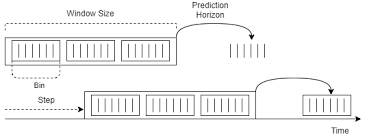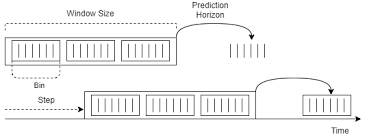

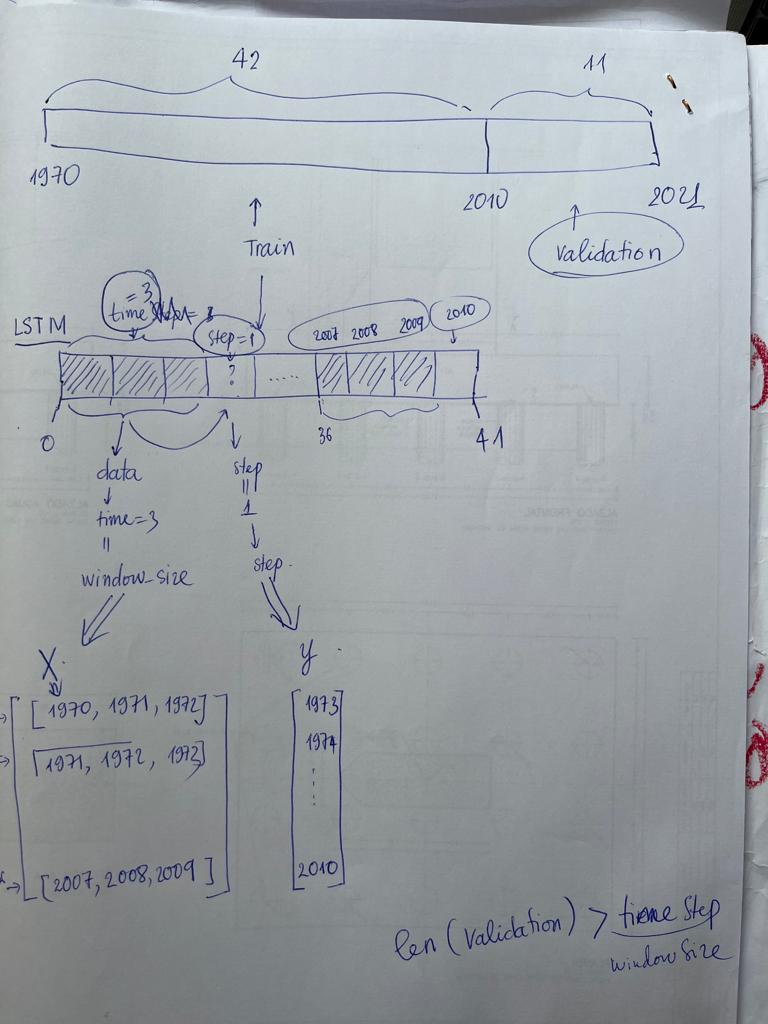


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_C)
scaled_df = pd.DataFrame(scaled_data, columns=df_C.columns)
scaled_df.set_index(df_C.index, inplace=True)

In [ ]:
scaled_df.head(3)

#### Prepare Functions

In [ ]:
# building input variable by creating a sliding window
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)

#### Prepare data

In [ ]:
# Assuming you have a DataFrame named df with a target column
sector='TRANSPORT'
#df=scaled_df.copy()
df=df_C.copy()
y=df[sector]
y_org=y.copy()

# Split data into train and test sets 
train_size = int(len(df_C) * 0.8)
y_train_org, y_val_org=y_org[:train_size],y_org[train_size:]
y = scaler.fit_transform(np.array(y).reshape(-1,1))
# Split data into train and val sets 

train, val = y[:train_size], y[train_size:]

##%%%%%%
time_step=3
# Create training dataset
X_train, y_train = create_dataset(train, time_step)

# Create validation dataset
X_val, y_val = create_dataset(val, time_step)

# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],time_step, 1)
X_val = X_val.reshape(X_val.shape[0],time_step, 1)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)

In [ ]:
y_val

#### Build model LSTM

In [ ]:
# Build model LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Summary
model.summary()

#### Fitting model

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val,y_val), verbose = 1,epochs = 60 ,batch_size = 200)

#### Evaluating

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
val_predict=model.predict(X_val)



# Reshape predictions if necessary
#train_predict = train_predict.reshape(-1, 1)
#val_predict = val_predict.reshape(-1, 1)


In [ ]:
train_predict.shape

In [ ]:
# Inverse transform the scaled predictions
train_predict_original = scaler.inverse_transform(train_predict)
val_predict_original = scaler.inverse_transform(val_predict)

In [ ]:
from sklearn.metrics import mean_squared_error
# Calculate the square root of mean squared error (rmse)
rmse = np.sqrt(mean_squared_error(y_train,train_predict))
print(f"RMSE: {rmse:.3f}")

In [ ]:
#train_predict_original

In [ ]:
y_train_original=scaler.inverse_transform(np.array(y_train).reshape(-1,1))
#y_train_original

In [ ]:
rmse = np.sqrt(mean_squared_error(y_train_original,train_predict_original))
print(f'Total values lost {rmse: .3f}')

In [ ]:
# Predicting consumption using training data

train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

actual = y_train_original.round(2)

df_train_results = pd.DataFrame()

df_train_results["Predict"] = train_predictions.tolist()
df_train_results["Actual"] = actual.tolist()

# Convert to a flat list
df_train_results["Predict"] = [item for sublist in df_train_results["Predict"] for item in sublist]
df_train_results["Actual"]=[item for sublist in df_train_results["Actual"] for item in sublist]

df_train_results["Predict +10%"] = df_train_results["Predict"] * 1.1
# Round the values of each column in the dataframe with 2 decimals
df_train_results = df_train_results.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

df_train_results.plot()



### Note:
We can observe that LSTM can be applied to predict future energy consumption with an accuracy of 10% in predicting data.

### Apply for all sectors

In [ ]:
#df=df_C.copy()

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 100, return_sequences = True, input_shape = (time_step, 1)))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.2))

    # # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

# Function to prepare data for LSTM
def prepare_lstm_data(df, time_steps):
    data = df.values
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Function to make predictions
def predict_with_lstm(model, X, scaler, start_date, periods):
    predictions = []
    for _ in range(periods):
        pred = model.predict(X[-1].reshape(1, X.shape[1], 1))
        pred = scaler.inverse_transform(pred)
        predictions.append(pred[0][0])
        # Append the predicted value to the input sequence for the next prediction
        X = np.append(X, pred).reshape(1, X.shape[1] + 1, 1)
    return predictions

# Load your DataFrame df_C here

# Number of time steps for LSTM
time_steps = 3

# DataFrame to store predictions
df_C_pred = pd.DataFrame()

for s in df_C.columns:
    df_sector = df_C[[s]]
    X, y, scaler = prepare_lstm_data(df_sector, time_steps)
    model = create_lstm_model(input_shape=(X.shape[1], 1))
    model.fit(X, y, epochs=60, batch_size=200, verbose=0)

    # Specify the number of future steps to forecast
    periods = 20  # Adjust as needed
    # Specify the start date
    start_date = pd.to_datetime('2022-01-01')

    # Make predictions for future time points
    predictions = predict_with_lstm(model, X, scaler, start_date, periods)

    # Create a date range for the forecasted period
    forecast_index = pd.date_range(start=start_date, periods=periods + 1, freq='Y')

    # Create a Pandas DataFrame with the forecasted values and set the index
    df_forecast = pd.DataFrame(data=predictions, index=forecast_index, columns=[s])

    # Plot (optional)
    plt.plot(df_sector, "b", label="Actual")
    plt.plot(df_forecast, "r", label="Forecast")

    plt.title(f"{s}")
    plt.legend()
    plt.show()

    # Concatenate df_forecast
    df_C_pred = pd.concat([df_C_pred, df_forecast], axis=1)

# Round the values of each column in the DataFrame with 2 decimals
df_C_pred = df_C_pred.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

# Reset index and save to Excel
df_C_pred.index = df_C_pred.index.year
file_name = 'df_C_pred.xlsx'
df_C_pred.to_excel(file_name)